### Repeated Prisioner's Dilemma

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is "discounting". Agents value future profits - they do not seek to maximize discounted sum. 

### Import Packages

In [17]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [18]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (1,1)
    if (a1 == 0 and a2 == 1): # DC
        return (3,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,3)
    if (a1 == 1 and a2 == 1): # CC
        return (2.5,2.5)
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            
            
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [20]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
BETA = 0.9
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [21]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:0.7569228410720825
Loss Agent1:0.6557750701904297

 Iteration: 209
Loss Agent0:0.8611729145050049
Loss Agent1:0.7556455135345459

 Iteration: 210
Loss Agent0:0.7972161173820496
Loss Agent1:0.7687256336212158

 Iteration: 211
Loss Agent0:0.8276368379592896
Loss Agent1:0.7393107414245605

 Iteration: 212
Loss Agent0:0.7782617211341858
Loss Agent1:0.7228988409042358

 Iteration: 213
Loss Agent0:0.7547715902328491
Loss Agent1:0.733345627784729

 Iteration: 214
Loss Agent0:0.7777364253997803
Loss Agent1:0.7710433006286621

 Iteration: 215
Loss Agent0:0.7685758471488953
Loss Agent1:0.7452607750892639

 Iteration: 216
Loss Agent0:0.8154507279396057
Loss Agent1:0.7649360299110413

 Iteration: 217
Loss Agent0:0.7807018756866455
Loss Agent1:0.6968811750411987

 Iteration: 218
Loss Agent0:0.7591552734375
Loss Agent1:0.6648212671279907

 Iteration: 219
Loss Agent0:0.7961876392364502
Loss Agent1:0.6636240482330322

 Iteration: 220
Loss Agent0:0.7697285413742065
Loss Agent1:0.62023925781

Loss Agent1:0.535582959651947

 Iteration: 320
Loss Agent0:0.584559977054596
Loss Agent1:0.6115329265594482

 Iteration: 321
Loss Agent0:0.5900546312332153
Loss Agent1:0.6147788166999817

 Iteration: 322
Loss Agent0:0.5753709077835083
Loss Agent1:0.5990325212478638

 Iteration: 323
Loss Agent0:0.6389771103858948
Loss Agent1:0.5556411743164062

 Iteration: 324
Loss Agent0:0.5724093914031982
Loss Agent1:0.5426617860794067

 Iteration: 325
Loss Agent0:0.5200824737548828
Loss Agent1:0.5108097791671753

 Iteration: 326
Loss Agent0:0.5852941274642944
Loss Agent1:0.4897974133491516

 Iteration: 327
Loss Agent0:0.5697920918464661
Loss Agent1:0.5003703832626343

 Iteration: 328
Loss Agent0:0.6112068891525269
Loss Agent1:0.522140383720398

 Iteration: 329
Loss Agent0:0.5525892376899719
Loss Agent1:0.48042020201683044

 Iteration: 330
Loss Agent0:0.6006413102149963
Loss Agent1:0.5438142418861389

 Iteration: 331
Loss Agent0:0.5993234515190125
Loss Agent1:0.5819016695022583

 Iteration: 332
Loss A

Loss Agent0:0.5954273343086243
Loss Agent1:0.5102007985115051

 Iteration: 435
Loss Agent0:0.563877522945404
Loss Agent1:0.5354230999946594

 Iteration: 436
Loss Agent0:0.5511816143989563
Loss Agent1:0.5160678625106812

 Iteration: 437
Loss Agent0:0.5332586765289307
Loss Agent1:0.5008053779602051

 Iteration: 438
Loss Agent0:0.5665143132209778
Loss Agent1:0.44366908073425293

 Iteration: 439
Loss Agent0:0.6452206373214722
Loss Agent1:0.4739500880241394

 Iteration: 440
Loss Agent0:0.5974372029304504
Loss Agent1:0.5342738032341003

 Iteration: 441
Loss Agent0:0.6001509428024292
Loss Agent1:0.5558384656906128

 Iteration: 442
Loss Agent0:0.6118834018707275
Loss Agent1:0.5458065867424011

 Iteration: 443
Loss Agent0:0.47476401925086975
Loss Agent1:0.5399296283721924

 Iteration: 444
Loss Agent0:0.5738905668258667
Loss Agent1:0.535424530506134

 Iteration: 445
Loss Agent0:0.569911003112793
Loss Agent1:0.4198944568634033

 Iteration: 446
Loss Agent0:0.5761486887931824
Loss Agent1:0.45413851

Loss Agent1:0.4344531297683716

 Iteration: 547
Loss Agent0:0.5548481941223145
Loss Agent1:0.532616376876831

 Iteration: 548
Loss Agent0:0.5527652502059937
Loss Agent1:0.38895270228385925

 Iteration: 549
Loss Agent0:0.5181479454040527
Loss Agent1:0.6015337109565735

 Iteration: 550
Loss Agent0:0.5442842841148376
Loss Agent1:0.5311914086341858

 Iteration: 551
Loss Agent0:0.4919658601284027
Loss Agent1:0.49115878343582153

 Iteration: 552
Loss Agent0:0.5368729829788208
Loss Agent1:0.4781825542449951

 Iteration: 553
Loss Agent0:0.548994243144989
Loss Agent1:0.45378538966178894

 Iteration: 554
Loss Agent0:0.49785277247428894
Loss Agent1:0.5249829888343811

 Iteration: 555
Loss Agent0:0.5152103900909424
Loss Agent1:0.4740305244922638

 Iteration: 556
Loss Agent0:0.6043373346328735
Loss Agent1:0.44532355666160583

 Iteration: 557
Loss Agent0:0.5187267661094666
Loss Agent1:0.5305474996566772

 Iteration: 558
Loss Agent0:0.5503264665603638
Loss Agent1:0.38128364086151123

 Iteration: 559


Loss Agent0:0.5462675094604492
Loss Agent1:0.43956464529037476

 Iteration: 664
Loss Agent0:0.5509485006332397
Loss Agent1:0.4337748885154724

 Iteration: 665
Loss Agent0:0.5879752039909363
Loss Agent1:0.44556599855422974

 Iteration: 666
Loss Agent0:0.4922422766685486
Loss Agent1:0.4596293866634369

 Iteration: 667
Loss Agent0:0.5059429407119751
Loss Agent1:0.45647844672203064

 Iteration: 668
Loss Agent0:0.49082887172698975
Loss Agent1:0.4541598856449127

 Iteration: 669
Loss Agent0:0.5117542743682861
Loss Agent1:0.4195539653301239

 Iteration: 670
Loss Agent0:0.48905622959136963
Loss Agent1:0.4122292399406433

 Iteration: 671
Loss Agent0:0.5488370656967163
Loss Agent1:0.43229371309280396

 Iteration: 672
Loss Agent0:0.48621436953544617
Loss Agent1:0.369562029838562

 Iteration: 673
Loss Agent0:0.5086675882339478
Loss Agent1:0.4769132435321808

 Iteration: 674
Loss Agent0:0.5679317712783813
Loss Agent1:0.4503929913043976

 Iteration: 675
Loss Agent0:0.5210138559341431
Loss Agent1:0.4

Loss Agent0:0.5274169445037842
Loss Agent1:0.43897274136543274

 Iteration: 771
Loss Agent0:0.4676322937011719
Loss Agent1:0.47552335262298584

 Iteration: 772
Loss Agent0:0.5442719459533691
Loss Agent1:0.3162682056427002

 Iteration: 773
Loss Agent0:0.5299794673919678
Loss Agent1:0.3617330491542816

 Iteration: 774
Loss Agent0:0.5249503254890442
Loss Agent1:0.48859503865242004

 Iteration: 775
Loss Agent0:0.47762489318847656
Loss Agent1:0.4632406234741211

 Iteration: 776
Loss Agent0:0.47905999422073364
Loss Agent1:0.4245380163192749

 Iteration: 777
Loss Agent0:0.4556443989276886
Loss Agent1:0.4325641989707947

 Iteration: 778
Loss Agent0:0.5239887237548828
Loss Agent1:0.35035717487335205

 Iteration: 779
Loss Agent0:0.5289205312728882
Loss Agent1:0.38909175992012024

 Iteration: 780
Loss Agent0:0.4826667606830597
Loss Agent1:0.4597530663013458

 Iteration: 781
Loss Agent0:0.4596221446990967
Loss Agent1:0.461627334356308

 Iteration: 782
Loss Agent0:0.5451647043228149
Loss Agent1:0.4

Loss Agent0:0.5177541375160217
Loss Agent1:0.5259830355644226

 Iteration: 883
Loss Agent0:0.5028240084648132
Loss Agent1:0.4522900879383087

 Iteration: 884
Loss Agent0:0.4781625270843506
Loss Agent1:0.4881303012371063

 Iteration: 885
Loss Agent0:0.4303898215293884
Loss Agent1:0.4393298029899597

 Iteration: 886
Loss Agent0:0.4392361640930176
Loss Agent1:0.3761272430419922

 Iteration: 887
Loss Agent0:0.5011419057846069
Loss Agent1:0.3921601176261902

 Iteration: 888
Loss Agent0:0.5326177477836609
Loss Agent1:0.48682430386543274

 Iteration: 889
Loss Agent0:0.4689056873321533
Loss Agent1:0.419024795293808

 Iteration: 890
Loss Agent0:0.46171391010284424
Loss Agent1:0.4457632601261139

 Iteration: 891
Loss Agent0:0.4568222761154175
Loss Agent1:0.3832123279571533

 Iteration: 892
Loss Agent0:0.49290597438812256
Loss Agent1:0.4921489655971527

 Iteration: 893
Loss Agent0:0.46591416001319885
Loss Agent1:0.4057500958442688

 Iteration: 894
Loss Agent0:0.3943268358707428
Loss Agent1:0.4348

Loss Agent1:0.4818950891494751

 Iteration: 992
Loss Agent0:0.6020178198814392
Loss Agent1:0.4136829972267151

 Iteration: 993
Loss Agent0:0.4970449209213257
Loss Agent1:0.431125283241272

 Iteration: 994
Loss Agent0:0.5190719366073608
Loss Agent1:0.41986769437789917

 Iteration: 995
Loss Agent0:0.42075446248054504
Loss Agent1:0.41176164150238037

 Iteration: 996
Loss Agent0:0.48155882954597473
Loss Agent1:0.3237197697162628

 Iteration: 997
Loss Agent0:0.454725980758667
Loss Agent1:0.35837697982788086

 Iteration: 998
Loss Agent0:0.4629133343696594
Loss Agent1:0.43527787923812866

 Iteration: 999
Loss Agent0:0.5449368357658386
Loss Agent1:0.37253955006599426

 Iteration: 1000
Loss Agent0:0.5087494254112244
Loss Agent1:0.42834150791168213

 Iteration: 1001
Loss Agent0:0.4308875501155853
Loss Agent1:0.37252911925315857

 Iteration: 1002
Loss Agent0:0.43721890449523926
Loss Agent1:0.4470612406730652

 Iteration: 1003
Loss Agent0:0.48086944222450256
Loss Agent1:0.3655521869659424

 Iterat

Loss Agent0:0.47432729601860046
Loss Agent1:0.43024367094039917

 Iteration: 1101
Loss Agent0:0.4945874810218811
Loss Agent1:0.3330521881580353

 Iteration: 1102
Loss Agent0:0.4065089225769043
Loss Agent1:0.5161882638931274

 Iteration: 1103
Loss Agent0:0.42114514112472534
Loss Agent1:0.3730032444000244

 Iteration: 1104
Loss Agent0:0.4316840171813965
Loss Agent1:0.36872366070747375

 Iteration: 1105
Loss Agent0:0.4026701748371124
Loss Agent1:0.3591046929359436

 Iteration: 1106
Loss Agent0:0.5049259066581726
Loss Agent1:0.3535131812095642

 Iteration: 1107
Loss Agent0:0.5080229043960571
Loss Agent1:0.3963968753814697

 Iteration: 1108
Loss Agent0:0.43431785702705383
Loss Agent1:0.4491579234600067

 Iteration: 1109
Loss Agent0:0.4913325309753418
Loss Agent1:0.44309768080711365

 Iteration: 1110
Loss Agent0:0.4032801687717438
Loss Agent1:0.4182983934879303

 Iteration: 1111
Loss Agent0:0.4351646304130554
Loss Agent1:0.38079410791397095

 Iteration: 1112
Loss Agent0:0.4412260055541992
Lo

Loss Agent1:0.4287228286266327

 Iteration: 1211
Loss Agent0:0.35677099227905273
Loss Agent1:0.3368261456489563

 Iteration: 1212
Loss Agent0:0.4674624800682068
Loss Agent1:0.4308148920536041

 Iteration: 1213
Loss Agent0:0.3943646550178528
Loss Agent1:0.3566400706768036

 Iteration: 1214
Loss Agent0:0.42125505208969116
Loss Agent1:0.32278263568878174

 Iteration: 1215
Loss Agent0:0.37598493695259094
Loss Agent1:0.34232282638549805

 Iteration: 1216
Loss Agent0:0.47569042444229126
Loss Agent1:0.3016388714313507

 Iteration: 1217
Loss Agent0:0.3979755640029907
Loss Agent1:0.4175443649291992

 Iteration: 1218
Loss Agent0:0.3263190984725952
Loss Agent1:0.4368821978569031

 Iteration: 1219
Loss Agent0:0.44095703959465027
Loss Agent1:0.35723116993904114

 Iteration: 1220
Loss Agent0:0.4607793092727661
Loss Agent1:0.3230782747268677

 Iteration: 1221
Loss Agent0:0.47510093450546265
Loss Agent1:0.3703595995903015

 Iteration: 1222
Loss Agent0:0.32555586099624634
Loss Agent1:0.4789276123046875


 Iteration: 1316
Loss Agent0:0.4373067617416382
Loss Agent1:0.4163503348827362

 Iteration: 1317
Loss Agent0:0.4198969304561615
Loss Agent1:0.37763333320617676

 Iteration: 1318
Loss Agent0:0.445074200630188
Loss Agent1:0.4404667615890503

 Iteration: 1319
Loss Agent0:0.5251950621604919
Loss Agent1:0.31530433893203735

 Iteration: 1320
Loss Agent0:0.43008917570114136
Loss Agent1:0.3543301522731781

 Iteration: 1321
Loss Agent0:0.4578988552093506
Loss Agent1:0.33813902735710144

 Iteration: 1322
Loss Agent0:0.4304395318031311
Loss Agent1:0.3246726989746094

 Iteration: 1323
Loss Agent0:0.46950432658195496
Loss Agent1:0.3538786470890045

 Iteration: 1324
Loss Agent0:0.41926953196525574
Loss Agent1:0.3291865885257721

 Iteration: 1325
Loss Agent0:0.45407572388648987
Loss Agent1:0.3546389639377594

 Iteration: 1326
Loss Agent0:0.4001725912094116
Loss Agent1:0.36335211992263794

 Iteration: 1327
Loss Agent0:0.46546387672424316
Loss Agent1:0.31079408526420593

 Iteration: 1328
Loss Agent0:0


 Iteration: 1419
Loss Agent0:0.41446733474731445
Loss Agent1:0.35004401206970215

 Iteration: 1420
Loss Agent0:0.3162430226802826
Loss Agent1:0.31447458267211914

 Iteration: 1421
Loss Agent0:0.43625015020370483
Loss Agent1:0.38753440976142883

 Iteration: 1422
Loss Agent0:0.3782522678375244
Loss Agent1:0.38444674015045166

 Iteration: 1423
Loss Agent0:0.3771088123321533
Loss Agent1:0.3182457685470581

 Iteration: 1424
Loss Agent0:0.3168480396270752
Loss Agent1:0.4143122434616089

 Iteration: 1425
Loss Agent0:0.399893194437027
Loss Agent1:0.3299359083175659

 Iteration: 1426
Loss Agent0:0.4064117670059204
Loss Agent1:0.29522794485092163

 Iteration: 1427
Loss Agent0:0.40938371419906616
Loss Agent1:0.38654857873916626

 Iteration: 1428
Loss Agent0:0.42698022723197937
Loss Agent1:0.378827840089798

 Iteration: 1429
Loss Agent0:0.3838118612766266
Loss Agent1:0.3167828619480133

 Iteration: 1430
Loss Agent0:0.40089279413223267
Loss Agent1:0.3194356858730316

 Iteration: 1431
Loss Agent0:0

Loss Agent0:0.3826419413089752
Loss Agent1:0.383478045463562

 Iteration: 1525
Loss Agent0:0.36883917450904846
Loss Agent1:0.3959900140762329

 Iteration: 1526
Loss Agent0:0.4390347898006439
Loss Agent1:0.3407159149646759

 Iteration: 1527
Loss Agent0:0.42321935296058655
Loss Agent1:0.3320333659648895

 Iteration: 1528
Loss Agent0:0.40728411078453064
Loss Agent1:0.4006103575229645

 Iteration: 1529
Loss Agent0:0.41133633255958557
Loss Agent1:0.34012430906295776

 Iteration: 1530
Loss Agent0:0.4620429575443268
Loss Agent1:0.3274536728858948

 Iteration: 1531
Loss Agent0:0.4441245198249817
Loss Agent1:0.3217029869556427

 Iteration: 1532
Loss Agent0:0.42168501019477844
Loss Agent1:0.30187058448791504

 Iteration: 1533
Loss Agent0:0.46490249037742615
Loss Agent1:0.33283481001853943

 Iteration: 1534
Loss Agent0:0.5026191473007202
Loss Agent1:0.38550880551338196

 Iteration: 1535
Loss Agent0:0.43642258644104004
Loss Agent1:0.27238523960113525

 Iteration: 1536
Loss Agent0:0.438843101263046


 Iteration: 1629
Loss Agent0:0.46695417165756226
Loss Agent1:0.2915051281452179

 Iteration: 1630
Loss Agent0:0.3376414179801941
Loss Agent1:0.2950800061225891

 Iteration: 1631
Loss Agent0:0.41058942675590515
Loss Agent1:0.3870740234851837

 Iteration: 1632
Loss Agent0:0.315119206905365
Loss Agent1:0.3968575894832611

 Iteration: 1633
Loss Agent0:0.4089970886707306
Loss Agent1:0.3164260983467102

 Iteration: 1634
Loss Agent0:0.3957166075706482
Loss Agent1:0.27991625666618347

 Iteration: 1635
Loss Agent0:0.3895566761493683
Loss Agent1:0.4031428098678589

 Iteration: 1636
Loss Agent0:0.42156946659088135
Loss Agent1:0.3143129348754883

 Iteration: 1637
Loss Agent0:0.4171183109283447
Loss Agent1:0.2707289159297943

 Iteration: 1638
Loss Agent0:0.4369922876358032
Loss Agent1:0.3517366647720337

 Iteration: 1639
Loss Agent0:0.3710154891014099
Loss Agent1:0.3433883786201477

 Iteration: 1640
Loss Agent0:0.3651520311832428
Loss Agent1:0.2694767117500305

 Iteration: 1641
Loss Agent0:0.38902

Loss Agent0:0.35600605607032776
Loss Agent1:0.29841139912605286

 Iteration: 1734
Loss Agent0:0.3840112090110779
Loss Agent1:0.3867794871330261

 Iteration: 1735
Loss Agent0:0.41966480016708374
Loss Agent1:0.2559804618358612

 Iteration: 1736
Loss Agent0:0.3241884410381317
Loss Agent1:0.2828763425350189

 Iteration: 1737
Loss Agent0:0.37871065735816956
Loss Agent1:0.36238372325897217

 Iteration: 1738
Loss Agent0:0.3260139226913452
Loss Agent1:0.33666613698005676

 Iteration: 1739
Loss Agent0:0.4385172426700592
Loss Agent1:0.37372025847435

 Iteration: 1740
Loss Agent0:0.3701818883419037
Loss Agent1:0.3573940098285675

 Iteration: 1741
Loss Agent0:0.34968066215515137
Loss Agent1:0.30909597873687744

 Iteration: 1742
Loss Agent0:0.37267473340034485
Loss Agent1:0.33654114603996277

 Iteration: 1743
Loss Agent0:0.31358832120895386
Loss Agent1:0.3417452871799469

 Iteration: 1744
Loss Agent0:0.4060613214969635
Loss Agent1:0.3355236053466797

 Iteration: 1745
Loss Agent0:0.33261117339134216

Loss Agent0:0.31488916277885437
Loss Agent1:0.3119240701198578

 Iteration: 1837
Loss Agent0:0.36767515540122986
Loss Agent1:0.33857735991477966

 Iteration: 1838
Loss Agent0:0.363412082195282
Loss Agent1:0.3658721148967743

 Iteration: 1839
Loss Agent0:0.3485654592514038
Loss Agent1:0.2846253216266632

 Iteration: 1840
Loss Agent0:0.3772927522659302
Loss Agent1:0.3411875367164612

 Iteration: 1841
Loss Agent0:0.3035537600517273
Loss Agent1:0.3755674362182617

 Iteration: 1842
Loss Agent0:0.35214683413505554
Loss Agent1:0.3194696605205536

 Iteration: 1843
Loss Agent0:0.4119854271411896
Loss Agent1:0.34108275175094604

 Iteration: 1844
Loss Agent0:0.3575707674026489
Loss Agent1:0.29884952306747437

 Iteration: 1845
Loss Agent0:0.3357498049736023
Loss Agent1:0.3592342138290405

 Iteration: 1846
Loss Agent0:0.3243233561515808
Loss Agent1:0.34241339564323425

 Iteration: 1847
Loss Agent0:0.36833056807518005
Loss Agent1:0.26410019397735596

 Iteration: 1848
Loss Agent0:0.36291787028312683


Loss Agent0:0.2864747643470764
Loss Agent1:0.2782675623893738

 Iteration: 1939
Loss Agent0:0.39542263746261597
Loss Agent1:0.2707265019416809

 Iteration: 1940
Loss Agent0:0.29017168283462524
Loss Agent1:0.3480122685432434

 Iteration: 1941
Loss Agent0:0.2959495782852173
Loss Agent1:0.3359990417957306

 Iteration: 1942
Loss Agent0:0.3588773012161255
Loss Agent1:0.3251999616622925

 Iteration: 1943
Loss Agent0:0.3737208843231201
Loss Agent1:0.29671162366867065

 Iteration: 1944
Loss Agent0:0.32950007915496826
Loss Agent1:0.240251362323761

 Iteration: 1945
Loss Agent0:0.3274555802345276
Loss Agent1:0.21983963251113892

 Iteration: 1946
Loss Agent0:0.4065023958683014
Loss Agent1:0.20007482171058655

 Iteration: 1947
Loss Agent0:0.3890702724456787
Loss Agent1:0.23999273777008057

 Iteration: 1948
Loss Agent0:0.38136932253837585
Loss Agent1:0.3283369243144989

 Iteration: 1949
Loss Agent0:0.33974209427833557
Loss Agent1:0.32534152269363403

 Iteration: 1950
Loss Agent0:0.3121313750743866


Loss Agent0:0.3626552224159241
Loss Agent1:0.2229594886302948

 Iteration: 2050
Loss Agent0:0.3469480276107788
Loss Agent1:0.3314407467842102

 Iteration: 2051
Loss Agent0:0.40829065442085266
Loss Agent1:0.3050417900085449

 Iteration: 2052
Loss Agent0:0.39370641112327576
Loss Agent1:0.23282942175865173

 Iteration: 2053
Loss Agent0:0.2937617897987366
Loss Agent1:0.24606817960739136

 Iteration: 2054
Loss Agent0:0.39757072925567627
Loss Agent1:0.26341789960861206

 Iteration: 2055
Loss Agent0:0.3574528694152832
Loss Agent1:0.23568607866764069

 Iteration: 2056
Loss Agent0:0.34874507784843445
Loss Agent1:0.28661930561065674

 Iteration: 2057
Loss Agent0:0.348655104637146
Loss Agent1:0.3293405771255493

 Iteration: 2058
Loss Agent0:0.3256123960018158
Loss Agent1:0.2682933211326599

 Iteration: 2059
Loss Agent0:0.2888037860393524
Loss Agent1:0.221621572971344

 Iteration: 2060
Loss Agent0:0.33432671427726746
Loss Agent1:0.21180203557014465

 Iteration: 2061
Loss Agent0:0.30927011370658875

Loss Agent0:0.2562076449394226
Loss Agent1:0.2845682203769684

 Iteration: 2157
Loss Agent0:0.3655139207839966
Loss Agent1:0.236107736825943

 Iteration: 2158
Loss Agent0:0.44504809379577637
Loss Agent1:0.31168076395988464

 Iteration: 2159
Loss Agent0:0.2745566666126251
Loss Agent1:0.2533286213874817

 Iteration: 2160
Loss Agent0:0.2933754026889801
Loss Agent1:0.20084989070892334

 Iteration: 2161
Loss Agent0:0.42030760645866394
Loss Agent1:0.33878108859062195

 Iteration: 2162
Loss Agent0:0.35332804918289185
Loss Agent1:0.2833598852157593

 Iteration: 2163
Loss Agent0:0.30932140350341797
Loss Agent1:0.3681865334510803

 Iteration: 2164
Loss Agent0:0.3392658233642578
Loss Agent1:0.2958071529865265

 Iteration: 2165
Loss Agent0:0.24648001790046692
Loss Agent1:0.26932597160339355

 Iteration: 2166
Loss Agent0:0.3406318724155426
Loss Agent1:0.2826358675956726

 Iteration: 2167
Loss Agent0:0.22832216322422028
Loss Agent1:0.3317011296749115

 Iteration: 2168
Loss Agent0:0.3999992609024048


Loss Agent0:0.3753098249435425
Loss Agent1:0.29431837797164917

 Iteration: 2260
Loss Agent0:0.3398378789424896
Loss Agent1:0.26643380522727966

 Iteration: 2261
Loss Agent0:0.3247337341308594
Loss Agent1:0.23574088513851166

 Iteration: 2262
Loss Agent0:0.29550087451934814
Loss Agent1:0.20406562089920044

 Iteration: 2263
Loss Agent0:0.41096776723861694
Loss Agent1:0.1705050766468048

 Iteration: 2264
Loss Agent0:0.29229068756103516
Loss Agent1:0.35244032740592957

 Iteration: 2265
Loss Agent0:0.26926806569099426
Loss Agent1:0.305099755525589

 Iteration: 2266
Loss Agent0:0.28837651014328003
Loss Agent1:0.37921807169914246

 Iteration: 2267
Loss Agent0:0.26741665601730347
Loss Agent1:0.37711453437805176

 Iteration: 2268
Loss Agent0:0.2844397723674774
Loss Agent1:0.34963834285736084

 Iteration: 2269
Loss Agent0:0.37441009283065796
Loss Agent1:0.22930653393268585

 Iteration: 2270
Loss Agent0:0.26166385412216187
Loss Agent1:0.2405465543270111

 Iteration: 2271
Loss Agent0:0.2825258672

Loss Agent0:0.21070167422294617
Loss Agent1:0.2872503399848938

 Iteration: 2364
Loss Agent0:0.26242321729660034
Loss Agent1:0.23494568467140198

 Iteration: 2365
Loss Agent0:0.31713777780532837
Loss Agent1:0.2936408519744873

 Iteration: 2366
Loss Agent0:0.26545751094818115
Loss Agent1:0.26904377341270447

 Iteration: 2367
Loss Agent0:0.31293922662734985
Loss Agent1:0.2077285200357437

 Iteration: 2368
Loss Agent0:0.31194499135017395
Loss Agent1:0.2805606424808502

 Iteration: 2369
Loss Agent0:0.34552061557769775
Loss Agent1:0.3113623559474945

 Iteration: 2370
Loss Agent0:0.3098771870136261
Loss Agent1:0.17566990852355957

 Iteration: 2371
Loss Agent0:0.24438682198524475
Loss Agent1:0.3210359513759613

 Iteration: 2372
Loss Agent0:0.3006563186645508
Loss Agent1:0.262645959854126

 Iteration: 2373
Loss Agent0:0.2608925998210907
Loss Agent1:0.26591676473617554

 Iteration: 2374
Loss Agent0:0.4043223261833191
Loss Agent1:0.2831879258155823

 Iteration: 2375
Loss Agent0:0.256875485181808

Loss Agent0:0.33578184247016907
Loss Agent1:0.30088096857070923

 Iteration: 2471
Loss Agent0:0.26825568079948425
Loss Agent1:0.28743016719818115

 Iteration: 2472
Loss Agent0:0.30082181096076965
Loss Agent1:0.3002839982509613

 Iteration: 2473
Loss Agent0:0.32685211300849915
Loss Agent1:0.28326499462127686

 Iteration: 2474
Loss Agent0:0.3524402976036072
Loss Agent1:0.266002357006073

 Iteration: 2475
Loss Agent0:0.3099305033683777
Loss Agent1:0.30848371982574463

 Iteration: 2476
Loss Agent0:0.3593788146972656
Loss Agent1:0.31560444831848145

 Iteration: 2477
Loss Agent0:0.3307640254497528
Loss Agent1:0.266651451587677

 Iteration: 2478
Loss Agent0:0.24711355566978455
Loss Agent1:0.3418455719947815

 Iteration: 2479
Loss Agent0:0.30990469455718994
Loss Agent1:0.2624196708202362

 Iteration: 2480
Loss Agent0:0.25187861919403076
Loss Agent1:0.3221646249294281

 Iteration: 2481
Loss Agent0:0.321826696395874
Loss Agent1:0.26626527309417725

 Iteration: 2482
Loss Agent0:0.2315079867839813

Loss Agent0:0.26373398303985596
Loss Agent1:0.2759958505630493

 Iteration: 2580
Loss Agent0:0.320041298866272
Loss Agent1:0.2640916705131531

 Iteration: 2581
Loss Agent0:0.34506112337112427
Loss Agent1:0.17160817980766296

 Iteration: 2582
Loss Agent0:0.2299836277961731
Loss Agent1:0.32043999433517456

 Iteration: 2583
Loss Agent0:0.3154655694961548
Loss Agent1:0.1978779435157776

 Iteration: 2584
Loss Agent0:0.2729576528072357
Loss Agent1:0.3198590576648712

 Iteration: 2585
Loss Agent0:0.33107686042785645
Loss Agent1:0.2897912859916687

 Iteration: 2586
Loss Agent0:0.25554490089416504
Loss Agent1:0.27563756704330444

 Iteration: 2587
Loss Agent0:0.2284294068813324
Loss Agent1:0.30858519673347473

 Iteration: 2588
Loss Agent0:0.2936253547668457
Loss Agent1:0.2826297879219055

 Iteration: 2589
Loss Agent0:0.2346804291009903
Loss Agent1:0.2590368390083313

 Iteration: 2590
Loss Agent0:0.21858638525009155
Loss Agent1:0.32534220814704895

 Iteration: 2591
Loss Agent0:0.3014189600944519


Loss Agent1:0.22962263226509094

 Iteration: 2686
Loss Agent0:0.2105908989906311
Loss Agent1:0.1200610101222992

 Iteration: 2687
Loss Agent0:0.28497904539108276
Loss Agent1:0.3019639253616333

 Iteration: 2688
Loss Agent0:0.2785472869873047
Loss Agent1:0.20812533795833588

 Iteration: 2689
Loss Agent0:0.28330421447753906
Loss Agent1:0.3440961539745331

 Iteration: 2690
Loss Agent0:0.23376476764678955
Loss Agent1:0.309432715177536

 Iteration: 2691
Loss Agent0:0.2488812357187271
Loss Agent1:0.28076016902923584

 Iteration: 2692
Loss Agent0:0.3141196072101593
Loss Agent1:0.2759610414505005

 Iteration: 2693
Loss Agent0:0.27265551686286926
Loss Agent1:0.28940677642822266

 Iteration: 2694
Loss Agent0:0.29980871081352234
Loss Agent1:0.19820240139961243

 Iteration: 2695
Loss Agent0:0.3040066063404083
Loss Agent1:0.18722295761108398

 Iteration: 2696
Loss Agent0:0.22084157168865204
Loss Agent1:0.22591815888881683

 Iteration: 2697
Loss Agent0:0.2695165276527405
Loss Agent1:0.26329031586647

Loss Agent0:0.27207696437835693
Loss Agent1:0.23374655842781067

 Iteration: 2792
Loss Agent0:0.2565578520298004
Loss Agent1:0.25201278924942017

 Iteration: 2793
Loss Agent0:0.28614500164985657
Loss Agent1:0.22436493635177612

 Iteration: 2794
Loss Agent0:0.26084575057029724
Loss Agent1:0.26585498452186584

 Iteration: 2795
Loss Agent0:0.2220059335231781
Loss Agent1:0.27138152718544006

 Iteration: 2796
Loss Agent0:0.1984560638666153
Loss Agent1:0.2842545211315155

 Iteration: 2797
Loss Agent0:0.265633225440979
Loss Agent1:0.1982482671737671

 Iteration: 2798
Loss Agent0:0.30132055282592773
Loss Agent1:0.30083221197128296

 Iteration: 2799
Loss Agent0:0.24721792340278625
Loss Agent1:0.19408491253852844

 Iteration: 2800
Loss Agent0:0.274370014667511
Loss Agent1:0.26355549693107605

 Iteration: 2801
Loss Agent0:0.3128136992454529
Loss Agent1:0.20402216911315918

 Iteration: 2802
Loss Agent0:0.2755652368068695
Loss Agent1:0.24699564278125763

 Iteration: 2803
Loss Agent0:0.2532091438770

Loss Agent0:0.2609666585922241
Loss Agent1:0.21189498901367188

 Iteration: 2903
Loss Agent0:0.23154079914093018
Loss Agent1:0.2630634009838104

 Iteration: 2904
Loss Agent0:0.31793034076690674
Loss Agent1:0.22884882986545563

 Iteration: 2905
Loss Agent0:0.2312946319580078
Loss Agent1:0.2766053378582001

 Iteration: 2906
Loss Agent0:0.30648669600486755
Loss Agent1:0.24153783917427063

 Iteration: 2907
Loss Agent0:0.2898448705673218
Loss Agent1:0.23184062540531158

 Iteration: 2908
Loss Agent0:0.19472356140613556
Loss Agent1:0.23188301920890808

 Iteration: 2909
Loss Agent0:0.2857533395290375
Loss Agent1:0.2876901626586914

 Iteration: 2910
Loss Agent0:0.27813732624053955
Loss Agent1:0.2202673703432083

 Iteration: 2911
Loss Agent0:0.34410008788108826
Loss Agent1:0.21098540723323822

 Iteration: 2912
Loss Agent0:0.22891460359096527
Loss Agent1:0.2116377055644989

 Iteration: 2913
Loss Agent0:0.2588033676147461
Loss Agent1:0.20470911264419556

 Iteration: 2914
Loss Agent0:0.350408911705

Loss Agent0:0.17670699954032898
Loss Agent1:0.20842914283275604

 Iteration: 3007
Loss Agent0:0.2692772448062897
Loss Agent1:0.1972995400428772

 Iteration: 3008
Loss Agent0:0.27840426564216614
Loss Agent1:0.21274568140506744

 Iteration: 3009
Loss Agent0:0.22587822377681732
Loss Agent1:0.2659588158130646

 Iteration: 3010
Loss Agent0:0.27151837944984436
Loss Agent1:0.18654364347457886

 Iteration: 3011
Loss Agent0:0.2692081928253174
Loss Agent1:0.20104147493839264

 Iteration: 3012
Loss Agent0:0.1791590303182602
Loss Agent1:0.21132755279541016

 Iteration: 3013
Loss Agent0:0.3107685148715973
Loss Agent1:0.20794880390167236

 Iteration: 3014
Loss Agent0:0.2542884349822998
Loss Agent1:0.19764788448810577

 Iteration: 3015
Loss Agent0:0.25178399682044983
Loss Agent1:0.21907445788383484

 Iteration: 3016
Loss Agent0:0.2203236222267151
Loss Agent1:0.1970217227935791

 Iteration: 3017
Loss Agent0:0.33134493231773376
Loss Agent1:0.27463388442993164

 Iteration: 3018
Loss Agent0:0.20008629560

Loss Agent0:0.27836912870407104
Loss Agent1:0.3200395107269287

 Iteration: 3112
Loss Agent0:0.22621551156044006
Loss Agent1:0.25003454089164734

 Iteration: 3113
Loss Agent0:0.2710316777229309
Loss Agent1:0.2459784746170044

 Iteration: 3114
Loss Agent0:0.26891592144966125
Loss Agent1:0.2427225261926651

 Iteration: 3115
Loss Agent0:0.2685776650905609
Loss Agent1:0.20320551097393036

 Iteration: 3116
Loss Agent0:0.2331920564174652
Loss Agent1:0.3135678768157959

 Iteration: 3117
Loss Agent0:0.2687508165836334
Loss Agent1:0.17737720906734467

 Iteration: 3118
Loss Agent0:0.23214960098266602
Loss Agent1:0.20584118366241455

 Iteration: 3119
Loss Agent0:0.2673802375793457
Loss Agent1:0.18139007687568665

 Iteration: 3120
Loss Agent0:0.14867834746837616
Loss Agent1:0.14909785985946655

 Iteration: 3121
Loss Agent0:0.22674095630645752
Loss Agent1:0.15942345559597015

 Iteration: 3122
Loss Agent0:0.27619433403015137
Loss Agent1:0.26860445737838745

 Iteration: 3123
Loss Agent0:0.29797405004

Loss Agent0:0.275660902261734
Loss Agent1:0.20103341341018677

 Iteration: 3215
Loss Agent0:0.34187987446784973
Loss Agent1:0.20430448651313782

 Iteration: 3216
Loss Agent0:0.22963660955429077
Loss Agent1:0.28172776103019714

 Iteration: 3217
Loss Agent0:0.28286707401275635
Loss Agent1:0.261639803647995

 Iteration: 3218
Loss Agent0:0.2717117667198181
Loss Agent1:0.2124168872833252

 Iteration: 3219
Loss Agent0:0.26263904571533203
Loss Agent1:0.186111181974411

 Iteration: 3220
Loss Agent0:0.18020866811275482
Loss Agent1:0.21922597289085388

 Iteration: 3221
Loss Agent0:0.2966225743293762
Loss Agent1:0.27914562821388245

 Iteration: 3222
Loss Agent0:0.23695853352546692
Loss Agent1:0.16218522191047668

 Iteration: 3223
Loss Agent0:0.2259085327386856
Loss Agent1:0.20126229524612427

 Iteration: 3224
Loss Agent0:0.23257645964622498
Loss Agent1:0.2429649382829666

 Iteration: 3225
Loss Agent0:0.13817717134952545
Loss Agent1:0.1297941356897354

 Iteration: 3226
Loss Agent0:0.33074206113815

Loss Agent0:0.19984009861946106
Loss Agent1:0.16886527836322784

 Iteration: 3324
Loss Agent0:0.26856690645217896
Loss Agent1:0.16910342872142792

 Iteration: 3325
Loss Agent0:0.34288525581359863
Loss Agent1:0.2091629058122635

 Iteration: 3326
Loss Agent0:0.27059972286224365
Loss Agent1:0.2654624581336975

 Iteration: 3327
Loss Agent0:0.3124018609523773
Loss Agent1:0.1828332394361496

 Iteration: 3328
Loss Agent0:0.2534509003162384
Loss Agent1:0.2021239548921585

 Iteration: 3329
Loss Agent0:0.20179566740989685
Loss Agent1:0.18191035091876984

 Iteration: 3330
Loss Agent0:0.2728603184223175
Loss Agent1:0.21748517453670502

 Iteration: 3331
Loss Agent0:0.18145321309566498
Loss Agent1:0.2139529436826706

 Iteration: 3332
Loss Agent0:0.2453288584947586
Loss Agent1:0.21596553921699524

 Iteration: 3333
Loss Agent0:0.2151423990726471
Loss Agent1:0.22733870148658752

 Iteration: 3334
Loss Agent0:0.27322694659233093
Loss Agent1:0.18029239773750305

 Iteration: 3335
Loss Agent0:0.303841054439

Loss Agent0:0.2501419186592102
Loss Agent1:0.28149935603141785

 Iteration: 3430
Loss Agent0:0.30627718567848206
Loss Agent1:0.2609694004058838

 Iteration: 3431
Loss Agent0:0.14904385805130005
Loss Agent1:0.1835983544588089

 Iteration: 3432
Loss Agent0:0.2654658257961273
Loss Agent1:0.1479487270116806

 Iteration: 3433
Loss Agent0:0.27818235754966736
Loss Agent1:0.21279537677764893

 Iteration: 3434
Loss Agent0:0.31649479269981384
Loss Agent1:0.1838253140449524

 Iteration: 3435
Loss Agent0:0.22747236490249634
Loss Agent1:0.20606279373168945

 Iteration: 3436
Loss Agent0:0.3128289580345154
Loss Agent1:0.1063012033700943

 Iteration: 3437
Loss Agent0:0.2040514051914215
Loss Agent1:0.30947378277778625

 Iteration: 3438
Loss Agent0:0.21262386441230774
Loss Agent1:0.20064111053943634

 Iteration: 3439
Loss Agent0:0.1944621503353119
Loss Agent1:0.21235166490077972

 Iteration: 3440
Loss Agent0:0.23517099022865295
Loss Agent1:0.14573895931243896

 Iteration: 3441
Loss Agent0:0.201241403818

Loss Agent0:0.23244348168373108
Loss Agent1:0.22465266287326813

 Iteration: 3534
Loss Agent0:0.13939812779426575
Loss Agent1:0.16560670733451843

 Iteration: 3535
Loss Agent0:0.21788430213928223
Loss Agent1:0.24862320721149445

 Iteration: 3536
Loss Agent0:0.2768465578556061
Loss Agent1:0.1996208131313324

 Iteration: 3537
Loss Agent0:0.2827434837818146
Loss Agent1:0.14549995958805084

 Iteration: 3538
Loss Agent0:0.17786145210266113
Loss Agent1:0.09058679640293121

 Iteration: 3539
Loss Agent0:0.2871285378932953
Loss Agent1:0.1132906973361969

 Iteration: 3540
Loss Agent0:0.2534938454627991
Loss Agent1:0.2645494341850281

 Iteration: 3541
Loss Agent0:0.3861226439476013
Loss Agent1:0.23518310487270355

 Iteration: 3542
Loss Agent0:0.22946110367774963
Loss Agent1:0.15254469215869904

 Iteration: 3543
Loss Agent0:0.2817131280899048
Loss Agent1:0.18821069598197937

 Iteration: 3544
Loss Agent0:0.1634286344051361
Loss Agent1:0.12659937143325806

 Iteration: 3545
Loss Agent0:0.284863024950


 Iteration: 3639
Loss Agent0:0.19955211877822876
Loss Agent1:0.23935317993164062

 Iteration: 3640
Loss Agent0:0.18919746577739716
Loss Agent1:0.18335582315921783

 Iteration: 3641
Loss Agent0:0.24086689949035645
Loss Agent1:0.22569602727890015

 Iteration: 3642
Loss Agent0:0.2144455760717392
Loss Agent1:0.13143247365951538

 Iteration: 3643
Loss Agent0:0.25277894735336304
Loss Agent1:0.1381494402885437

 Iteration: 3644
Loss Agent0:0.26462510228157043
Loss Agent1:0.19716531038284302

 Iteration: 3645
Loss Agent0:0.2434183955192566
Loss Agent1:0.13391965627670288

 Iteration: 3646
Loss Agent0:0.2934306263923645
Loss Agent1:0.24841547012329102

 Iteration: 3647
Loss Agent0:0.26836708188056946
Loss Agent1:0.21549716591835022

 Iteration: 3648
Loss Agent0:0.1933574080467224
Loss Agent1:0.1834632009267807

 Iteration: 3649
Loss Agent0:0.2810184061527252
Loss Agent1:0.23111039400100708

 Iteration: 3650
Loss Agent0:0.14844177663326263
Loss Agent1:0.11566171050071716

 Iteration: 3651
Loss 

Loss Agent0:0.1644674688577652
Loss Agent1:0.16499467194080353

 Iteration: 3744
Loss Agent0:0.22508783638477325
Loss Agent1:0.20675241947174072

 Iteration: 3745
Loss Agent0:0.3086228370666504
Loss Agent1:0.2007269561290741

 Iteration: 3746
Loss Agent0:0.23691600561141968
Loss Agent1:0.18622398376464844

 Iteration: 3747
Loss Agent0:0.2394322007894516
Loss Agent1:0.22902880609035492

 Iteration: 3748
Loss Agent0:0.15384112298488617
Loss Agent1:0.22109827399253845

 Iteration: 3749
Loss Agent0:0.19696451723575592
Loss Agent1:0.19323015213012695

 Iteration: 3750
Loss Agent0:0.22971627116203308
Loss Agent1:0.1640254706144333

 Iteration: 3751
Loss Agent0:0.22276650369167328
Loss Agent1:0.17680205404758453

 Iteration: 3752
Loss Agent0:0.1981990486383438
Loss Agent1:0.14890004694461823

 Iteration: 3753
Loss Agent0:0.20291411876678467
Loss Agent1:0.22526317834854126

 Iteration: 3754
Loss Agent0:0.18499916791915894
Loss Agent1:0.15522097051143646

 Iteration: 3755
Loss Agent0:0.31629762

Loss Agent0:0.2843746542930603
Loss Agent1:0.18595650792121887

 Iteration: 3849
Loss Agent0:0.15539146959781647
Loss Agent1:0.23497402667999268

 Iteration: 3850
Loss Agent0:0.1455456167459488
Loss Agent1:0.16268765926361084

 Iteration: 3851
Loss Agent0:0.16825562715530396
Loss Agent1:0.17336034774780273

 Iteration: 3852
Loss Agent0:0.21452295780181885
Loss Agent1:0.1903776228427887

 Iteration: 3853
Loss Agent0:0.12232739478349686
Loss Agent1:0.21342933177947998

 Iteration: 3854
Loss Agent0:0.2778637707233429
Loss Agent1:0.14795397222042084

 Iteration: 3855
Loss Agent0:0.20458155870437622
Loss Agent1:0.1477506011724472

 Iteration: 3856
Loss Agent0:0.2620545029640198
Loss Agent1:0.23610948026180267

 Iteration: 3857
Loss Agent0:0.22503800690174103
Loss Agent1:0.1580582857131958

 Iteration: 3858
Loss Agent0:0.21224509179592133
Loss Agent1:0.14885912835597992

 Iteration: 3859
Loss Agent0:0.1816960573196411
Loss Agent1:0.3124564588069916

 Iteration: 3860
Loss Agent0:0.25844094157

Loss Agent0:0.18625584244728088
Loss Agent1:0.18488509953022003

 Iteration: 3957
Loss Agent0:0.21739059686660767
Loss Agent1:0.17977148294448853

 Iteration: 3958
Loss Agent0:0.23444843292236328
Loss Agent1:0.11148425191640854

 Iteration: 3959
Loss Agent0:0.14771202206611633
Loss Agent1:0.15667490661144257

 Iteration: 3960
Loss Agent0:0.24300086498260498
Loss Agent1:0.2249162495136261

 Iteration: 3961
Loss Agent0:0.22326527535915375
Loss Agent1:0.16829954087734222

 Iteration: 3962
Loss Agent0:0.2930842638015747
Loss Agent1:0.2723582983016968

 Iteration: 3963
Loss Agent0:0.20393508672714233
Loss Agent1:0.2653832733631134

 Iteration: 3964
Loss Agent0:0.1460995376110077
Loss Agent1:0.22437947988510132

 Iteration: 3965
Loss Agent0:0.21190589666366577
Loss Agent1:0.17686063051223755

 Iteration: 3966
Loss Agent0:0.1927359253168106
Loss Agent1:0.15238992869853973

 Iteration: 3967
Loss Agent0:0.23443706333637238
Loss Agent1:0.17028699815273285

 Iteration: 3968
Loss Agent0:0.19268625

Loss Agent1:0.17075268924236298

 Iteration: 4059
Loss Agent0:0.20517578721046448
Loss Agent1:0.13480274379253387

 Iteration: 4060
Loss Agent0:0.24520573019981384
Loss Agent1:0.24514140188694

 Iteration: 4061
Loss Agent0:0.18352194130420685
Loss Agent1:0.17099663615226746

 Iteration: 4062
Loss Agent0:0.2652580738067627
Loss Agent1:0.20816490054130554

 Iteration: 4063
Loss Agent0:0.14493580162525177
Loss Agent1:0.23668968677520752

 Iteration: 4064
Loss Agent0:0.19088532030582428
Loss Agent1:0.19655992090702057

 Iteration: 4065
Loss Agent0:0.2068750560283661
Loss Agent1:0.19235818088054657

 Iteration: 4066
Loss Agent0:0.23402085900306702
Loss Agent1:0.19960233569145203

 Iteration: 4067
Loss Agent0:0.21305537223815918
Loss Agent1:0.16021320223808289

 Iteration: 4068
Loss Agent0:0.2698627710342407
Loss Agent1:0.1966157853603363

 Iteration: 4069
Loss Agent0:0.10066808760166168
Loss Agent1:0.1257316768169403

 Iteration: 4070
Loss Agent0:0.2460791915655136
Loss Agent1:0.14585283398

Loss Agent0:0.2260337769985199
Loss Agent1:0.14009296894073486

 Iteration: 4168
Loss Agent0:0.2938337028026581
Loss Agent1:0.2115701138973236

 Iteration: 4169
Loss Agent0:0.2004510760307312
Loss Agent1:0.20030122995376587

 Iteration: 4170
Loss Agent0:0.20019881427288055
Loss Agent1:0.11185843497514725

 Iteration: 4171
Loss Agent0:0.18775345385074615
Loss Agent1:0.14515124261379242

 Iteration: 4172
Loss Agent0:0.2126052975654602
Loss Agent1:0.2164093554019928

 Iteration: 4173
Loss Agent0:0.2892499268054962
Loss Agent1:0.2044309675693512

 Iteration: 4174
Loss Agent0:0.22879518568515778
Loss Agent1:0.17874324321746826

 Iteration: 4175
Loss Agent0:0.26465076208114624
Loss Agent1:0.15217623114585876

 Iteration: 4176
Loss Agent0:0.2540142238140106
Loss Agent1:0.17091336846351624

 Iteration: 4177
Loss Agent0:0.2304363250732422
Loss Agent1:0.18532559275627136

 Iteration: 4178
Loss Agent0:0.21262966096401215
Loss Agent1:0.1605084091424942

 Iteration: 4179
Loss Agent0:0.1169312745332

Loss Agent0:0.30189549922943115
Loss Agent1:0.13517053425312042

 Iteration: 4271
Loss Agent0:0.28959786891937256
Loss Agent1:0.21984991431236267

 Iteration: 4272
Loss Agent0:0.2340376377105713
Loss Agent1:0.2033170461654663

 Iteration: 4273
Loss Agent0:0.1773076206445694
Loss Agent1:0.19641101360321045

 Iteration: 4274
Loss Agent0:0.17436793446540833
Loss Agent1:0.22027796506881714

 Iteration: 4275
Loss Agent0:0.21801674365997314
Loss Agent1:0.2192123383283615

 Iteration: 4276
Loss Agent0:0.18171222507953644
Loss Agent1:0.11344540864229202

 Iteration: 4277
Loss Agent0:0.2629891633987427
Loss Agent1:0.1280878782272339

 Iteration: 4278
Loss Agent0:0.18121498823165894
Loss Agent1:0.15755490958690643

 Iteration: 4279
Loss Agent0:0.12475106865167618
Loss Agent1:0.20445524156093597

 Iteration: 4280
Loss Agent0:0.20796558260917664
Loss Agent1:0.17079943418502808

 Iteration: 4281
Loss Agent0:0.1769404262304306
Loss Agent1:0.1466066986322403

 Iteration: 4282
Loss Agent0:0.1750327348

Loss Agent0:0.15273426473140717
Loss Agent1:0.23437128961086273

 Iteration: 4375
Loss Agent0:0.16251790523529053
Loss Agent1:0.13115271925926208

 Iteration: 4376
Loss Agent0:0.2224450260400772
Loss Agent1:0.15528102219104767

 Iteration: 4377
Loss Agent0:0.1885272115468979
Loss Agent1:0.1899120956659317

 Iteration: 4378
Loss Agent0:0.2577008008956909
Loss Agent1:0.1715458631515503

 Iteration: 4379
Loss Agent0:0.2845149040222168
Loss Agent1:0.14990119636058807

 Iteration: 4380
Loss Agent0:0.1579713374376297
Loss Agent1:0.20606261491775513

 Iteration: 4381
Loss Agent0:0.13815650343894958
Loss Agent1:0.12497751414775848

 Iteration: 4382
Loss Agent0:0.26153719425201416
Loss Agent1:0.13902156054973602

 Iteration: 4383
Loss Agent0:0.2090582400560379
Loss Agent1:0.2096242904663086

 Iteration: 4384
Loss Agent0:0.23077060282230377
Loss Agent1:0.1998116374015808

 Iteration: 4385
Loss Agent0:0.21621012687683105
Loss Agent1:0.1770440936088562

 Iteration: 4386
Loss Agent0:0.2871866524219

Loss Agent0:0.26578083634376526
Loss Agent1:0.15922869741916656

 Iteration: 4485
Loss Agent0:0.19553998112678528
Loss Agent1:0.19940704107284546

 Iteration: 4486
Loss Agent0:0.20455487072467804
Loss Agent1:0.12567900121212006

 Iteration: 4487
Loss Agent0:0.14348676800727844
Loss Agent1:0.12987421452999115

 Iteration: 4488
Loss Agent0:0.21955811977386475
Loss Agent1:0.17166118323802948

 Iteration: 4489
Loss Agent0:0.22195100784301758
Loss Agent1:0.24854479730129242

 Iteration: 4490
Loss Agent0:0.17736394703388214
Loss Agent1:0.2171163558959961

 Iteration: 4491
Loss Agent0:0.15232691168785095
Loss Agent1:0.18782109022140503

 Iteration: 4492
Loss Agent0:0.15648451447486877
Loss Agent1:0.2557355463504791

 Iteration: 4493
Loss Agent0:0.20045983791351318
Loss Agent1:0.15798170864582062

 Iteration: 4494
Loss Agent0:0.1646101325750351
Loss Agent1:0.23403149843215942

 Iteration: 4495
Loss Agent0:0.19535209238529205
Loss Agent1:0.1574103683233261

 Iteration: 4496
Loss Agent0:0.225079

Loss Agent0:0.2376999855041504
Loss Agent1:0.13336554169654846

 Iteration: 4590
Loss Agent0:0.20452407002449036
Loss Agent1:0.13212206959724426

 Iteration: 4591
Loss Agent0:0.25880637764930725
Loss Agent1:0.14346183836460114

 Iteration: 4592
Loss Agent0:0.1889316290616989
Loss Agent1:0.1649061143398285

 Iteration: 4593
Loss Agent0:0.18535740673542023
Loss Agent1:0.09873029589653015

 Iteration: 4594
Loss Agent0:0.19985467195510864
Loss Agent1:0.18313433229923248

 Iteration: 4595
Loss Agent0:0.2662336528301239
Loss Agent1:0.17926806211471558

 Iteration: 4596
Loss Agent0:0.20297138392925262
Loss Agent1:0.22423155605793

 Iteration: 4597
Loss Agent0:0.19876785576343536
Loss Agent1:0.1990583837032318

 Iteration: 4598
Loss Agent0:0.16794927418231964
Loss Agent1:0.13235196471214294

 Iteration: 4599
Loss Agent0:0.23074345290660858
Loss Agent1:0.23288583755493164

 Iteration: 4600
Loss Agent0:0.17136339843273163
Loss Agent1:0.15485388040542603

 Iteration: 4601
Loss Agent0:0.2248500883

Loss Agent0:0.23838499188423157
Loss Agent1:0.1454736292362213

 Iteration: 4697
Loss Agent0:0.18928779661655426
Loss Agent1:0.11889662593603134

 Iteration: 4698
Loss Agent0:0.24111893773078918
Loss Agent1:0.18275396525859833

 Iteration: 4699
Loss Agent0:0.15790441632270813
Loss Agent1:0.12564235925674438

 Iteration: 4700
Loss Agent0:0.24755598604679108
Loss Agent1:0.11979281902313232

 Iteration: 4701
Loss Agent0:0.17661158740520477
Loss Agent1:0.18854489922523499

 Iteration: 4702
Loss Agent0:0.17644771933555603
Loss Agent1:0.16874635219573975

 Iteration: 4703
Loss Agent0:0.22373884916305542
Loss Agent1:0.20378419756889343

 Iteration: 4704
Loss Agent0:0.11669204384088516
Loss Agent1:0.1844450980424881

 Iteration: 4705
Loss Agent0:0.24429923295974731
Loss Agent1:0.27625733613967896

 Iteration: 4706
Loss Agent0:0.19251613318920135
Loss Agent1:0.11929731070995331

 Iteration: 4707
Loss Agent0:0.22283926606178284
Loss Agent1:0.19707560539245605

 Iteration: 4708
Loss Agent0:0.2303

Loss Agent0:0.2455289214849472
Loss Agent1:0.22968482971191406

 Iteration: 4804
Loss Agent0:0.23593413829803467
Loss Agent1:0.16057562828063965

 Iteration: 4805
Loss Agent0:0.1339091807603836
Loss Agent1:0.14346511662006378

 Iteration: 4806
Loss Agent0:0.2143174409866333
Loss Agent1:0.10057099163532257

 Iteration: 4807
Loss Agent0:0.2257043719291687
Loss Agent1:0.16150420904159546

 Iteration: 4808
Loss Agent0:0.25974902510643005
Loss Agent1:0.1721145659685135

 Iteration: 4809
Loss Agent0:0.1667136549949646
Loss Agent1:0.125911146402359

 Iteration: 4810
Loss Agent0:0.26034677028656006
Loss Agent1:0.24033573269844055

 Iteration: 4811
Loss Agent0:0.14748910069465637
Loss Agent1:0.14933878183364868

 Iteration: 4812
Loss Agent0:0.16255883872509003
Loss Agent1:0.1599455028772354

 Iteration: 4813
Loss Agent0:0.20012491941452026
Loss Agent1:0.15319466590881348

 Iteration: 4814
Loss Agent0:0.21588832139968872
Loss Agent1:0.21597623825073242

 Iteration: 4815
Loss Agent0:0.21218317747

Loss Agent0:0.22181054949760437
Loss Agent1:0.15559129416942596

 Iteration: 4913
Loss Agent0:0.2669241428375244
Loss Agent1:0.16490881145000458

 Iteration: 4914
Loss Agent0:0.19936206936836243
Loss Agent1:0.22433708608150482

 Iteration: 4915
Loss Agent0:0.13972462713718414
Loss Agent1:0.15732817351818085

 Iteration: 4916
Loss Agent0:0.19228491187095642
Loss Agent1:0.13319431245326996

 Iteration: 4917
Loss Agent0:0.15461304783821106
Loss Agent1:0.11096792668104172

 Iteration: 4918
Loss Agent0:0.17126305401325226
Loss Agent1:0.10832801461219788

 Iteration: 4919
Loss Agent0:0.17776024341583252
Loss Agent1:0.17209374904632568

 Iteration: 4920
Loss Agent0:0.2296687364578247
Loss Agent1:0.12690874934196472

 Iteration: 4921
Loss Agent0:0.16586950421333313
Loss Agent1:0.12734562158584595

 Iteration: 4922
Loss Agent0:0.1118035688996315
Loss Agent1:0.14854012429714203

 Iteration: 4923
Loss Agent0:0.06507467478513718
Loss Agent1:0.09470658004283905

 Iteration: 4924
Loss Agent0:0.10974

Loss Agent0:0.20310106873512268
Loss Agent1:0.136383518576622

 Iteration: 5020
Loss Agent0:0.15978682041168213
Loss Agent1:0.11962247639894485

 Iteration: 5021
Loss Agent0:0.24065500497817993
Loss Agent1:0.08938033133745193

 Iteration: 5022
Loss Agent0:0.2110622525215149
Loss Agent1:0.21470171213150024

 Iteration: 5023
Loss Agent0:0.20973914861679077
Loss Agent1:0.07607054710388184

 Iteration: 5024
Loss Agent0:0.1667199730873108
Loss Agent1:0.16348841786384583

 Iteration: 5025
Loss Agent0:0.10993640124797821
Loss Agent1:0.1686922162771225

 Iteration: 5026
Loss Agent0:0.15445202589035034
Loss Agent1:0.17143511772155762

 Iteration: 5027
Loss Agent0:0.22864042222499847
Loss Agent1:0.1857464611530304

 Iteration: 5028
Loss Agent0:0.1399209052324295
Loss Agent1:0.10247328877449036

 Iteration: 5029
Loss Agent0:0.14846712350845337
Loss Agent1:0.1463218331336975

 Iteration: 5030
Loss Agent0:0.1329585760831833
Loss Agent1:0.16882430016994476

 Iteration: 5031
Loss Agent0:0.21582838892

Loss Agent0:0.1744944155216217
Loss Agent1:0.13211534917354584

 Iteration: 5124
Loss Agent0:0.21201017498970032
Loss Agent1:0.10995990037918091

 Iteration: 5125
Loss Agent0:0.23648715019226074
Loss Agent1:0.218758687376976

 Iteration: 5126
Loss Agent0:0.19205138087272644
Loss Agent1:0.1375175565481186

 Iteration: 5127
Loss Agent0:0.19486799836158752
Loss Agent1:0.057233892381191254

 Iteration: 5128
Loss Agent0:0.20298688113689423
Loss Agent1:0.14250047504901886

 Iteration: 5129
Loss Agent0:0.1736539602279663
Loss Agent1:0.1326882541179657

 Iteration: 5130
Loss Agent0:0.24416382610797882
Loss Agent1:0.18302682042121887

 Iteration: 5131
Loss Agent0:0.14270202815532684
Loss Agent1:0.17924973368644714

 Iteration: 5132
Loss Agent0:0.14343604445457458
Loss Agent1:0.1500340700149536

 Iteration: 5133
Loss Agent0:0.21688279509544373
Loss Agent1:0.13545826077461243

 Iteration: 5134
Loss Agent0:0.17118781805038452
Loss Agent1:0.17691224813461304

 Iteration: 5135
Loss Agent0:0.14080235

Loss Agent1:0.12496403604745865

 Iteration: 5228
Loss Agent0:0.14404289424419403
Loss Agent1:0.0796947106719017

 Iteration: 5229
Loss Agent0:0.1329810917377472
Loss Agent1:0.15631553530693054

 Iteration: 5230
Loss Agent0:0.21021178364753723
Loss Agent1:0.16265924274921417

 Iteration: 5231
Loss Agent0:0.18911606073379517
Loss Agent1:0.14797671139240265

 Iteration: 5232
Loss Agent0:0.1869623214006424
Loss Agent1:0.13616254925727844

 Iteration: 5233
Loss Agent0:0.21505522727966309
Loss Agent1:0.12157375365495682

 Iteration: 5234
Loss Agent0:0.15784448385238647
Loss Agent1:0.1362558752298355

 Iteration: 5235
Loss Agent0:0.2275877445936203
Loss Agent1:0.1386490911245346

 Iteration: 5236
Loss Agent0:0.13248895108699799
Loss Agent1:0.10996750742197037

 Iteration: 5237
Loss Agent0:0.1440914273262024
Loss Agent1:0.12761858105659485

 Iteration: 5238
Loss Agent0:0.25754842162132263
Loss Agent1:0.10717757046222687

 Iteration: 5239
Loss Agent0:0.22108101844787598
Loss Agent1:0.154863044

Loss Agent0:0.26382917165756226
Loss Agent1:0.08483552932739258

 Iteration: 5335
Loss Agent0:0.22085559368133545
Loss Agent1:0.20259125530719757

 Iteration: 5336
Loss Agent0:0.17781469225883484
Loss Agent1:0.10916456580162048

 Iteration: 5337
Loss Agent0:0.17877130210399628
Loss Agent1:0.1559816300868988

 Iteration: 5338
Loss Agent0:0.14437472820281982
Loss Agent1:0.15162134170532227

 Iteration: 5339
Loss Agent0:0.14346632361412048
Loss Agent1:0.21491633355617523

 Iteration: 5340
Loss Agent0:0.14992421865463257
Loss Agent1:0.16516922414302826

 Iteration: 5341
Loss Agent0:0.1960582435131073
Loss Agent1:0.18968605995178223

 Iteration: 5342
Loss Agent0:0.17275601625442505
Loss Agent1:0.14895141124725342

 Iteration: 5343
Loss Agent0:0.1325790137052536
Loss Agent1:0.17040446400642395

 Iteration: 5344
Loss Agent0:0.142981618642807
Loss Agent1:0.19236287474632263

 Iteration: 5345
Loss Agent0:0.2024219036102295
Loss Agent1:0.09850794821977615

 Iteration: 5346
Loss Agent0:0.24801218

Loss Agent0:0.12160079926252365
Loss Agent1:0.11795873194932938

 Iteration: 5436
Loss Agent0:0.17945608496665955
Loss Agent1:0.16466137766838074

 Iteration: 5437
Loss Agent0:0.17013481259346008
Loss Agent1:0.12916193902492523

 Iteration: 5438
Loss Agent0:0.23475441336631775
Loss Agent1:0.14159749448299408

 Iteration: 5439
Loss Agent0:0.10109648108482361
Loss Agent1:0.1494007706642151

 Iteration: 5440
Loss Agent0:0.14677990972995758
Loss Agent1:0.19310298562049866

 Iteration: 5441
Loss Agent0:0.15202146768569946
Loss Agent1:0.14415942132472992

 Iteration: 5442
Loss Agent0:0.14836904406547546
Loss Agent1:0.14895743131637573

 Iteration: 5443
Loss Agent0:0.15452221035957336
Loss Agent1:0.21550479531288147

 Iteration: 5444
Loss Agent0:0.158030167222023
Loss Agent1:0.1569775491952896

 Iteration: 5445
Loss Agent0:0.2136220633983612
Loss Agent1:0.17440451681613922

 Iteration: 5446
Loss Agent0:0.18713581562042236
Loss Agent1:0.17613525688648224

 Iteration: 5447
Loss Agent0:0.2365665

Loss Agent0:0.10450328141450882
Loss Agent1:0.09593649953603745

 Iteration: 5543
Loss Agent0:0.12446491420269012
Loss Agent1:0.14050953090190887

 Iteration: 5544
Loss Agent0:0.23124830424785614
Loss Agent1:0.13289658725261688

 Iteration: 5545
Loss Agent0:0.17940834164619446
Loss Agent1:0.11224308609962463

 Iteration: 5546
Loss Agent0:0.14342275261878967
Loss Agent1:0.2071557343006134

 Iteration: 5547
Loss Agent0:0.1680675595998764
Loss Agent1:0.09617127478122711

 Iteration: 5548
Loss Agent0:0.17527221143245697
Loss Agent1:0.14832836389541626

 Iteration: 5549
Loss Agent0:0.18929699063301086
Loss Agent1:0.08578421175479889

 Iteration: 5550
Loss Agent0:0.11877959966659546
Loss Agent1:0.11736682057380676

 Iteration: 5551
Loss Agent0:0.15927614271640778
Loss Agent1:0.191761314868927

 Iteration: 5552
Loss Agent0:0.06530847400426865
Loss Agent1:0.17830660939216614

 Iteration: 5553
Loss Agent0:0.195515438914299
Loss Agent1:0.18764348328113556

 Iteration: 5554
Loss Agent0:0.21887214

Loss Agent0:0.17925682663917542
Loss Agent1:0.10872738063335419

 Iteration: 5651
Loss Agent0:0.17051061987876892
Loss Agent1:0.18253621459007263

 Iteration: 5652
Loss Agent0:0.12964753806591034
Loss Agent1:0.11139880865812302

 Iteration: 5653
Loss Agent0:0.1648256629705429
Loss Agent1:0.19546616077423096

 Iteration: 5654
Loss Agent0:0.17894737422466278
Loss Agent1:0.1597459763288498

 Iteration: 5655
Loss Agent0:0.20063523948192596
Loss Agent1:0.19782043993473053

 Iteration: 5656
Loss Agent0:0.1432008594274521
Loss Agent1:0.18844172358512878

 Iteration: 5657
Loss Agent0:0.1569775491952896
Loss Agent1:0.20838266611099243

 Iteration: 5658
Loss Agent0:0.13557901978492737
Loss Agent1:0.09871957451105118

 Iteration: 5659
Loss Agent0:0.19722378253936768
Loss Agent1:0.14616060256958008

 Iteration: 5660
Loss Agent0:0.20937244594097137
Loss Agent1:0.12671740353107452

 Iteration: 5661
Loss Agent0:0.16146685183048248
Loss Agent1:0.22197382152080536

 Iteration: 5662
Loss Agent0:0.105879

Loss Agent0:0.20064935088157654
Loss Agent1:0.20695067942142487

 Iteration: 5756
Loss Agent0:0.23140445351600647
Loss Agent1:0.14374418556690216

 Iteration: 5757
Loss Agent0:0.1351311057806015
Loss Agent1:0.08809803426265717

 Iteration: 5758
Loss Agent0:0.12450484186410904
Loss Agent1:0.13855470716953278

 Iteration: 5759
Loss Agent0:0.22165505588054657
Loss Agent1:0.1063140258193016

 Iteration: 5760
Loss Agent0:0.1665673553943634
Loss Agent1:0.09683030098676682

 Iteration: 5761
Loss Agent0:0.21291354298591614
Loss Agent1:0.20741134881973267

 Iteration: 5762
Loss Agent0:0.21017152070999146
Loss Agent1:0.17944017052650452

 Iteration: 5763
Loss Agent0:0.1209663599729538
Loss Agent1:0.1927396059036255

 Iteration: 5764
Loss Agent0:0.19814351201057434
Loss Agent1:0.15557648241519928

 Iteration: 5765
Loss Agent0:0.17822226881980896
Loss Agent1:0.15614615380764008

 Iteration: 5766
Loss Agent0:0.14903166890144348
Loss Agent1:0.11664976179599762

 Iteration: 5767
Loss Agent0:0.1939434


 Iteration: 5860
Loss Agent0:0.2514753043651581
Loss Agent1:0.1243123933672905

 Iteration: 5861
Loss Agent0:0.11983664333820343
Loss Agent1:0.13779863715171814

 Iteration: 5862
Loss Agent0:0.13614380359649658
Loss Agent1:0.11652064323425293

 Iteration: 5863
Loss Agent0:0.14994974434375763
Loss Agent1:0.15236112475395203

 Iteration: 5864
Loss Agent0:0.15849660336971283
Loss Agent1:0.16390298306941986

 Iteration: 5865
Loss Agent0:0.1683908998966217
Loss Agent1:0.13248170912265778

 Iteration: 5866
Loss Agent0:0.16173748672008514
Loss Agent1:0.12092922627925873

 Iteration: 5867
Loss Agent0:0.15636295080184937
Loss Agent1:0.2468331903219223

 Iteration: 5868
Loss Agent0:0.16606523096561432
Loss Agent1:0.1555185317993164

 Iteration: 5869
Loss Agent0:0.17075364291667938
Loss Agent1:0.17126382887363434

 Iteration: 5870
Loss Agent0:0.224824458360672
Loss Agent1:0.1040014773607254

 Iteration: 5871
Loss Agent0:0.1903221309185028
Loss Agent1:0.0868670865893364

 Iteration: 5872
Loss Age

Loss Agent0:0.13140806555747986
Loss Agent1:0.17063087224960327

 Iteration: 5963
Loss Agent0:0.1323707401752472
Loss Agent1:0.14416596293449402

 Iteration: 5964
Loss Agent0:0.18827196955680847
Loss Agent1:0.13329581916332245

 Iteration: 5965
Loss Agent0:0.14014364778995514
Loss Agent1:0.22454680502414703

 Iteration: 5966
Loss Agent0:0.27858972549438477
Loss Agent1:0.09420499205589294

 Iteration: 5967
Loss Agent0:0.11359688639640808
Loss Agent1:0.15702462196350098

 Iteration: 5968
Loss Agent0:0.19567546248435974
Loss Agent1:0.10498932749032974

 Iteration: 5969
Loss Agent0:0.20474214851856232
Loss Agent1:0.222010537981987

 Iteration: 5970
Loss Agent0:0.2239486128091812
Loss Agent1:0.13240882754325867

 Iteration: 5971
Loss Agent0:0.0972672626376152
Loss Agent1:0.11010627448558807

 Iteration: 5972
Loss Agent0:0.15102888643741608
Loss Agent1:0.2052675187587738

 Iteration: 5973
Loss Agent0:0.18130627274513245
Loss Agent1:0.16532018780708313

 Iteration: 5974
Loss Agent0:0.15619145


 Iteration: 6068
Loss Agent0:0.20045645534992218
Loss Agent1:0.1322329044342041

 Iteration: 6069
Loss Agent0:0.12839844822883606
Loss Agent1:0.08603242039680481

 Iteration: 6070
Loss Agent0:0.22735896706581116
Loss Agent1:0.13836203515529633

 Iteration: 6071
Loss Agent0:0.13443507254123688
Loss Agent1:0.21597810089588165

 Iteration: 6072
Loss Agent0:0.08916421979665756
Loss Agent1:0.11788029968738556

 Iteration: 6073
Loss Agent0:0.12765872478485107
Loss Agent1:0.1467628926038742

 Iteration: 6074
Loss Agent0:0.16079075634479523
Loss Agent1:0.12506750226020813

 Iteration: 6075
Loss Agent0:0.14262647926807404
Loss Agent1:0.16339856386184692

 Iteration: 6076
Loss Agent0:0.12483224272727966
Loss Agent1:0.1483340561389923

 Iteration: 6077
Loss Agent0:0.10807006061077118
Loss Agent1:0.13242539763450623

 Iteration: 6078
Loss Agent0:0.12797053158283234
Loss Agent1:0.16046978533267975

 Iteration: 6079
Loss Agent0:0.18782438337802887
Loss Agent1:0.218461275100708

 Iteration: 6080
Los

Loss Agent0:0.15325455367565155
Loss Agent1:0.17763926088809967

 Iteration: 6176
Loss Agent0:0.12380791455507278
Loss Agent1:0.1374361515045166

 Iteration: 6177
Loss Agent0:0.2105821669101715
Loss Agent1:0.16889363527297974

 Iteration: 6178
Loss Agent0:0.17705567181110382
Loss Agent1:0.09627639502286911

 Iteration: 6179
Loss Agent0:0.2149936705827713
Loss Agent1:0.09670203924179077

 Iteration: 6180
Loss Agent0:0.15893641114234924
Loss Agent1:0.16521431505680084

 Iteration: 6181
Loss Agent0:0.17526446282863617
Loss Agent1:0.1541963517665863

 Iteration: 6182
Loss Agent0:0.15537869930267334
Loss Agent1:0.1107940599322319

 Iteration: 6183
Loss Agent0:0.22713720798492432
Loss Agent1:0.1288221925497055

 Iteration: 6184
Loss Agent0:0.17794382572174072
Loss Agent1:0.1687263399362564

 Iteration: 6185
Loss Agent0:0.1364741325378418
Loss Agent1:0.12128060311079025

 Iteration: 6186
Loss Agent0:0.1947529911994934
Loss Agent1:0.06899841874837875

 Iteration: 6187
Loss Agent0:0.15879699587

Loss Agent0:0.06350062787532806
Loss Agent1:0.10835260897874832

 Iteration: 6278
Loss Agent0:0.19287598133087158
Loss Agent1:0.1468806117773056

 Iteration: 6279
Loss Agent0:0.2048547863960266
Loss Agent1:0.10963863134384155

 Iteration: 6280
Loss Agent0:0.11891839653253555
Loss Agent1:0.24048706889152527

 Iteration: 6281
Loss Agent0:0.13513503968715668
Loss Agent1:0.13190506398677826

 Iteration: 6282
Loss Agent0:0.1784639060497284
Loss Agent1:0.18026164174079895

 Iteration: 6283
Loss Agent0:0.12370016425848007
Loss Agent1:0.12186088413000107

 Iteration: 6284
Loss Agent0:0.17631423473358154
Loss Agent1:0.12644197046756744

 Iteration: 6285
Loss Agent0:0.1888335645198822
Loss Agent1:0.20300358533859253

 Iteration: 6286
Loss Agent0:0.14025703072547913
Loss Agent1:0.09377419948577881

 Iteration: 6287
Loss Agent0:0.21807418763637543
Loss Agent1:0.1329576075077057

 Iteration: 6288
Loss Agent0:0.18667690455913544
Loss Agent1:0.10241479426622391

 Iteration: 6289
Loss Agent0:0.1006177

Loss Agent0:0.20741766691207886
Loss Agent1:0.11559236794710159

 Iteration: 6381
Loss Agent0:0.21164247393608093
Loss Agent1:0.1896010935306549

 Iteration: 6382
Loss Agent0:0.22214257717132568
Loss Agent1:0.11066523939371109

 Iteration: 6383
Loss Agent0:0.1539956033229828
Loss Agent1:0.13945575058460236

 Iteration: 6384
Loss Agent0:0.1603887677192688
Loss Agent1:0.10703872889280319

 Iteration: 6385
Loss Agent0:0.11363190412521362
Loss Agent1:0.178329199552536

 Iteration: 6386
Loss Agent0:0.11507130414247513
Loss Agent1:0.16796450316905975

 Iteration: 6387
Loss Agent0:0.15389969944953918
Loss Agent1:0.0960380882024765

 Iteration: 6388
Loss Agent0:0.15969672799110413
Loss Agent1:0.17161168158054352

 Iteration: 6389
Loss Agent0:0.14631620049476624
Loss Agent1:0.14113427698612213

 Iteration: 6390
Loss Agent0:0.1567833423614502
Loss Agent1:0.1491539627313614

 Iteration: 6391
Loss Agent0:0.10697106271982193
Loss Agent1:0.18212801218032837

 Iteration: 6392
Loss Agent0:0.1311416774

Loss Agent0:0.08399099856615067
Loss Agent1:0.09587158262729645

 Iteration: 6482
Loss Agent0:0.14085857570171356
Loss Agent1:0.1400221884250641

 Iteration: 6483
Loss Agent0:0.13228285312652588
Loss Agent1:0.14687861502170563

 Iteration: 6484
Loss Agent0:0.09608481824398041
Loss Agent1:0.10999691486358643

 Iteration: 6485
Loss Agent0:0.21054211258888245
Loss Agent1:0.1330186426639557

 Iteration: 6486
Loss Agent0:0.11811132729053497
Loss Agent1:0.129200741648674

 Iteration: 6487
Loss Agent0:0.18160215020179749
Loss Agent1:0.11775307357311249

 Iteration: 6488
Loss Agent0:0.13838376104831696
Loss Agent1:0.08832475543022156

 Iteration: 6489
Loss Agent0:0.10434380173683167
Loss Agent1:0.12431584298610687

 Iteration: 6490
Loss Agent0:0.12883484363555908
Loss Agent1:0.1578371226787567

 Iteration: 6491
Loss Agent0:0.18920545279979706
Loss Agent1:0.16092008352279663

 Iteration: 6492
Loss Agent0:0.14011234045028687
Loss Agent1:0.11322224885225296

 Iteration: 6493
Loss Agent0:0.1540190

Loss Agent0:0.13137605786323547
Loss Agent1:0.20117507874965668

 Iteration: 6591
Loss Agent0:0.09556601941585541
Loss Agent1:0.12413898855447769

 Iteration: 6592
Loss Agent0:0.17764608561992645
Loss Agent1:0.14289766550064087

 Iteration: 6593
Loss Agent0:0.15895965695381165
Loss Agent1:0.08937545120716095

 Iteration: 6594
Loss Agent0:0.24566474556922913
Loss Agent1:0.10740528255701065

 Iteration: 6595
Loss Agent0:0.13186845183372498
Loss Agent1:0.11780380457639694

 Iteration: 6596
Loss Agent0:0.15404047071933746
Loss Agent1:0.13805557787418365

 Iteration: 6597
Loss Agent0:0.11275309324264526
Loss Agent1:0.10967768728733063

 Iteration: 6598
Loss Agent0:0.10257409512996674
Loss Agent1:0.11553288996219635

 Iteration: 6599
Loss Agent0:0.24618667364120483
Loss Agent1:0.10071177780628204

 Iteration: 6600
Loss Agent0:0.10445190966129303
Loss Agent1:0.13614849746227264

 Iteration: 6601
Loss Agent0:0.13328707218170166
Loss Agent1:0.16939225792884827

 Iteration: 6602
Loss Agent0:0.17

Loss Agent0:0.15644395351409912
Loss Agent1:0.1610209196805954

 Iteration: 6700
Loss Agent0:0.09916037321090698
Loss Agent1:0.10421863198280334

 Iteration: 6701
Loss Agent0:0.10044432431459427
Loss Agent1:0.15060946345329285

 Iteration: 6702
Loss Agent0:0.19098696112632751
Loss Agent1:0.17576618492603302

 Iteration: 6703
Loss Agent0:0.09555260837078094
Loss Agent1:0.05431310087442398

 Iteration: 6704
Loss Agent0:0.11888837814331055
Loss Agent1:0.1576257199048996

 Iteration: 6705
Loss Agent0:0.19797766208648682
Loss Agent1:0.15425358712673187

 Iteration: 6706
Loss Agent0:0.18689297139644623
Loss Agent1:0.14342233538627625

 Iteration: 6707
Loss Agent0:0.29140427708625793
Loss Agent1:0.07722679525613785

 Iteration: 6708
Loss Agent0:0.17084456980228424
Loss Agent1:0.1879364252090454

 Iteration: 6709
Loss Agent0:0.15924909710884094
Loss Agent1:0.21121421456336975

 Iteration: 6710
Loss Agent0:0.11704810708761215
Loss Agent1:0.1324901431798935

 Iteration: 6711
Loss Agent0:0.101876

Loss Agent0:0.1401679664850235
Loss Agent1:0.11348684132099152

 Iteration: 6806
Loss Agent0:0.0977901741862297
Loss Agent1:0.1133815348148346

 Iteration: 6807
Loss Agent0:0.22383186221122742
Loss Agent1:0.13596020638942719

 Iteration: 6808
Loss Agent0:0.12634655833244324
Loss Agent1:0.15116585791110992

 Iteration: 6809
Loss Agent0:0.17564935982227325
Loss Agent1:0.16619917750358582

 Iteration: 6810
Loss Agent0:0.16755825281143188
Loss Agent1:0.07752828299999237

 Iteration: 6811
Loss Agent0:0.15395306050777435
Loss Agent1:0.0856008380651474

 Iteration: 6812
Loss Agent0:0.11077042669057846
Loss Agent1:0.15492039918899536

 Iteration: 6813
Loss Agent0:0.1406731903553009
Loss Agent1:0.12410998344421387

 Iteration: 6814
Loss Agent0:0.20848864316940308
Loss Agent1:0.135498046875

 Iteration: 6815
Loss Agent0:0.1292475312948227
Loss Agent1:0.10766329616308212

 Iteration: 6816
Loss Agent0:0.10663272440433502
Loss Agent1:0.1692027449607849

 Iteration: 6817
Loss Agent0:0.10954371839761

Loss Agent1:0.11004064977169037

 Iteration: 6908
Loss Agent0:0.1301119178533554
Loss Agent1:0.15291908383369446

 Iteration: 6909
Loss Agent0:0.11562477052211761
Loss Agent1:0.13260523974895477

 Iteration: 6910
Loss Agent0:0.21839390695095062
Loss Agent1:0.162314310669899

 Iteration: 6911
Loss Agent0:0.21523907780647278
Loss Agent1:0.085006482899189

 Iteration: 6912
Loss Agent0:0.13467146456241608
Loss Agent1:0.10705985873937607

 Iteration: 6913
Loss Agent0:0.1366955041885376
Loss Agent1:0.0712258592247963

 Iteration: 6914
Loss Agent0:0.18646326661109924
Loss Agent1:0.11787831783294678

 Iteration: 6915
Loss Agent0:0.1957387924194336
Loss Agent1:0.09259721636772156

 Iteration: 6916
Loss Agent0:0.1454339474439621
Loss Agent1:0.10304515063762665

 Iteration: 6917
Loss Agent0:0.16266845166683197
Loss Agent1:0.14007897675037384

 Iteration: 6918
Loss Agent0:0.1561976671218872
Loss Agent1:0.13642963767051697

 Iteration: 6919
Loss Agent0:0.07319588959217072
Loss Agent1:0.159042671322

Loss Agent0:0.13785552978515625
Loss Agent1:0.11045871675014496

 Iteration: 7017
Loss Agent0:0.16979865729808807
Loss Agent1:0.1068156361579895

 Iteration: 7018
Loss Agent0:0.15337075293064117
Loss Agent1:0.10320155322551727

 Iteration: 7019
Loss Agent0:0.1280035376548767
Loss Agent1:0.10720540583133698

 Iteration: 7020
Loss Agent0:0.2630031108856201
Loss Agent1:0.2083485871553421

 Iteration: 7021
Loss Agent0:0.1523105502128601
Loss Agent1:0.1873578131198883

 Iteration: 7022
Loss Agent0:0.1265266239643097
Loss Agent1:0.14779841899871826

 Iteration: 7023
Loss Agent0:0.19723010063171387
Loss Agent1:0.18395771086215973

 Iteration: 7024
Loss Agent0:0.14078018069267273
Loss Agent1:0.09046533703804016

 Iteration: 7025
Loss Agent0:0.2080129086971283
Loss Agent1:0.18249273300170898

 Iteration: 7026
Loss Agent0:0.14570944011211395
Loss Agent1:0.15523865818977356

 Iteration: 7027
Loss Agent0:0.14103010296821594
Loss Agent1:0.13078442215919495

 Iteration: 7028
Loss Agent0:0.0872733816

Loss Agent1:0.1013987585902214

 Iteration: 7118
Loss Agent0:0.10064253211021423
Loss Agent1:0.09651323407888412

 Iteration: 7119
Loss Agent0:0.16231687366962433
Loss Agent1:0.13351155817508698

 Iteration: 7120
Loss Agent0:0.10909327119588852
Loss Agent1:0.08741933107376099

 Iteration: 7121
Loss Agent0:0.12150989472866058
Loss Agent1:0.07588601857423782

 Iteration: 7122
Loss Agent0:0.1452624499797821
Loss Agent1:0.12443321943283081

 Iteration: 7123
Loss Agent0:0.19058123230934143
Loss Agent1:0.13308297097682953

 Iteration: 7124
Loss Agent0:0.11511129140853882
Loss Agent1:0.12109016627073288

 Iteration: 7125
Loss Agent0:0.1097702756524086
Loss Agent1:0.12101748585700989

 Iteration: 7126
Loss Agent0:0.23441600799560547
Loss Agent1:0.1542934626340866

 Iteration: 7127
Loss Agent0:0.19830814003944397
Loss Agent1:0.0855637788772583

 Iteration: 7128
Loss Agent0:0.14871759712696075
Loss Agent1:0.0779447928071022

 Iteration: 7129
Loss Agent0:0.1345977634191513
Loss Agent1:0.085229963

Loss Agent0:0.14301657676696777
Loss Agent1:0.1609956920146942

 Iteration: 7219
Loss Agent0:0.17546947300434113
Loss Agent1:0.09484872221946716

 Iteration: 7220
Loss Agent0:0.09144638478755951
Loss Agent1:0.15246231853961945

 Iteration: 7221
Loss Agent0:0.10665109753608704
Loss Agent1:0.14889778196811676

 Iteration: 7222
Loss Agent0:0.14551004767417908
Loss Agent1:0.10540901124477386

 Iteration: 7223
Loss Agent0:0.13836009800434113
Loss Agent1:0.10888033360242844

 Iteration: 7224
Loss Agent0:0.1743016541004181
Loss Agent1:0.09689492732286453

 Iteration: 7225
Loss Agent0:0.17423686385154724
Loss Agent1:0.14291971921920776

 Iteration: 7226
Loss Agent0:0.09943605214357376
Loss Agent1:0.1021658256649971

 Iteration: 7227
Loss Agent0:0.1466217190027237
Loss Agent1:0.14678941667079926

 Iteration: 7228
Loss Agent0:0.1632789522409439
Loss Agent1:0.07365540415048599

 Iteration: 7229
Loss Agent0:0.10763942450284958
Loss Agent1:0.11674550175666809

 Iteration: 7230
Loss Agent0:0.2180019

Loss Agent0:0.20164704322814941
Loss Agent1:0.13539430499076843

 Iteration: 7327
Loss Agent0:0.14395356178283691
Loss Agent1:0.11081670224666595

 Iteration: 7328
Loss Agent0:0.14341095089912415
Loss Agent1:0.09462939202785492

 Iteration: 7329
Loss Agent0:0.14288939535617828
Loss Agent1:0.09333136677742004

 Iteration: 7330
Loss Agent0:0.1507137417793274
Loss Agent1:0.08820533007383347

 Iteration: 7331
Loss Agent0:0.16402196884155273
Loss Agent1:0.12149497121572495

 Iteration: 7332
Loss Agent0:0.1233045756816864
Loss Agent1:0.12104415148496628

 Iteration: 7333
Loss Agent0:0.09098321199417114
Loss Agent1:0.1187940463423729

 Iteration: 7334
Loss Agent0:0.13651658594608307
Loss Agent1:0.12162721157073975

 Iteration: 7335
Loss Agent0:0.060493648052215576
Loss Agent1:0.13637790083885193

 Iteration: 7336
Loss Agent0:0.11458054184913635
Loss Agent1:0.12445402890443802

 Iteration: 7337
Loss Agent0:0.13665702939033508
Loss Agent1:0.16884657740592957

 Iteration: 7338
Loss Agent0:0.1301

Loss Agent0:0.12298782914876938
Loss Agent1:0.07591032236814499

 Iteration: 7431
Loss Agent0:0.09541590511798859
Loss Agent1:0.12173736095428467

 Iteration: 7432
Loss Agent0:0.13401274383068085
Loss Agent1:0.07672515511512756

 Iteration: 7433
Loss Agent0:0.17918922007083893
Loss Agent1:0.15268415212631226

 Iteration: 7434
Loss Agent0:0.15020689368247986
Loss Agent1:0.16070827841758728

 Iteration: 7435
Loss Agent0:0.06437986344099045
Loss Agent1:0.1514696329832077

 Iteration: 7436
Loss Agent0:0.174943208694458
Loss Agent1:0.11342780292034149

 Iteration: 7437
Loss Agent0:0.1132005900144577
Loss Agent1:0.183652862906456

 Iteration: 7438
Loss Agent0:0.21009193360805511
Loss Agent1:0.07782218605279922

 Iteration: 7439
Loss Agent0:0.1540471315383911
Loss Agent1:0.13919520378112793

 Iteration: 7440
Loss Agent0:0.10553659498691559
Loss Agent1:0.05049057677388191

 Iteration: 7441
Loss Agent0:0.08419531583786011
Loss Agent1:0.1054021567106247

 Iteration: 7442
Loss Agent0:0.1449743211

Loss Agent0:0.21310314536094666
Loss Agent1:0.1346813589334488

 Iteration: 7540
Loss Agent0:0.1314694583415985
Loss Agent1:0.11622480303049088

 Iteration: 7541
Loss Agent0:0.11652114242315292
Loss Agent1:0.16625861823558807

 Iteration: 7542
Loss Agent0:0.08655018359422684
Loss Agent1:0.13830718398094177

 Iteration: 7543
Loss Agent0:0.13481515645980835
Loss Agent1:0.12149835377931595

 Iteration: 7544
Loss Agent0:0.18931584060192108
Loss Agent1:0.1469360888004303

 Iteration: 7545
Loss Agent0:0.11708994209766388
Loss Agent1:0.1331430971622467

 Iteration: 7546
Loss Agent0:0.09874462336301804
Loss Agent1:0.08813562989234924

 Iteration: 7547
Loss Agent0:0.09226056933403015
Loss Agent1:0.12099042534828186

 Iteration: 7548
Loss Agent0:0.18725766241550446
Loss Agent1:0.1202002540230751

 Iteration: 7549
Loss Agent0:0.13128921389579773
Loss Agent1:0.1300409585237503

 Iteration: 7550
Loss Agent0:0.15599870681762695
Loss Agent1:0.1322658658027649

 Iteration: 7551
Loss Agent0:0.152965739

Loss Agent0:0.18633873760700226
Loss Agent1:0.07561711221933365

 Iteration: 7646
Loss Agent0:0.10870478302240372
Loss Agent1:0.13539430499076843

 Iteration: 7647
Loss Agent0:0.172076016664505
Loss Agent1:0.09921342134475708

 Iteration: 7648
Loss Agent0:0.17098966240882874
Loss Agent1:0.09363044798374176

 Iteration: 7649
Loss Agent0:0.1757289618253708
Loss Agent1:0.11475136876106262

 Iteration: 7650
Loss Agent0:0.16485610604286194
Loss Agent1:0.09354782849550247

 Iteration: 7651
Loss Agent0:0.18206503987312317
Loss Agent1:0.08734948933124542

 Iteration: 7652
Loss Agent0:0.11070908606052399
Loss Agent1:0.05869278684258461

 Iteration: 7653
Loss Agent0:0.1738564670085907
Loss Agent1:0.11928800493478775

 Iteration: 7654
Loss Agent0:0.08558225631713867
Loss Agent1:0.0874413326382637

 Iteration: 7655
Loss Agent0:0.13727980852127075
Loss Agent1:0.1399674117565155

 Iteration: 7656
Loss Agent0:0.12928085029125214
Loss Agent1:0.13613727688789368

 Iteration: 7657
Loss Agent0:0.08760386

Loss Agent0:0.09641940891742706
Loss Agent1:0.11467098444700241

 Iteration: 7747
Loss Agent0:0.18873465061187744
Loss Agent1:0.09313678741455078

 Iteration: 7748
Loss Agent0:0.23209281265735626
Loss Agent1:0.08706052601337433

 Iteration: 7749
Loss Agent0:0.13101407885551453
Loss Agent1:0.04795839637517929

 Iteration: 7750
Loss Agent0:0.18666589260101318
Loss Agent1:0.1299733817577362

 Iteration: 7751
Loss Agent0:0.14382845163345337
Loss Agent1:0.07136131823062897

 Iteration: 7752
Loss Agent0:0.11674901098012924
Loss Agent1:0.09638731926679611

 Iteration: 7753
Loss Agent0:0.13292524218559265
Loss Agent1:0.05331653356552124

 Iteration: 7754
Loss Agent0:0.12082995474338531
Loss Agent1:0.1529276818037033

 Iteration: 7755
Loss Agent0:0.07184292376041412
Loss Agent1:0.03633003681898117

 Iteration: 7756
Loss Agent0:0.14511345326900482
Loss Agent1:0.14951811730861664

 Iteration: 7757
Loss Agent0:0.11598000675439835
Loss Agent1:0.09893295913934708

 Iteration: 7758
Loss Agent0:0.0965

Loss Agent1:0.05437995493412018

 Iteration: 7853
Loss Agent0:0.10035400837659836
Loss Agent1:0.11313334107398987

 Iteration: 7854
Loss Agent0:0.1755024790763855
Loss Agent1:0.09550051391124725

 Iteration: 7855
Loss Agent0:0.11497977375984192
Loss Agent1:0.110142283141613

 Iteration: 7856
Loss Agent0:0.07298433780670166
Loss Agent1:0.13218985497951508

 Iteration: 7857
Loss Agent0:0.08460640907287598
Loss Agent1:0.12109185755252838

 Iteration: 7858
Loss Agent0:0.11768721044063568
Loss Agent1:0.11309336870908737

 Iteration: 7859
Loss Agent0:0.11496594548225403
Loss Agent1:0.08463557809591293

 Iteration: 7860
Loss Agent0:0.13681727647781372
Loss Agent1:0.06455624848604202

 Iteration: 7861
Loss Agent0:0.12891437113285065
Loss Agent1:0.13793107867240906

 Iteration: 7862
Loss Agent0:0.06283271312713623
Loss Agent1:0.053641803562641144

 Iteration: 7863
Loss Agent0:0.17983750998973846
Loss Agent1:0.13262023031711578

 Iteration: 7864
Loss Agent0:0.19831113517284393
Loss Agent1:0.0874

Loss Agent0:0.19342100620269775
Loss Agent1:0.10962558537721634

 Iteration: 7960
Loss Agent0:0.1419360488653183
Loss Agent1:0.11848950386047363

 Iteration: 7961
Loss Agent0:0.14476308226585388
Loss Agent1:0.12380744516849518

 Iteration: 7962
Loss Agent0:0.20968149602413177
Loss Agent1:0.11043335497379303

 Iteration: 7963
Loss Agent0:0.09949159622192383
Loss Agent1:0.12416882812976837

 Iteration: 7964
Loss Agent0:0.13096989691257477
Loss Agent1:0.09300372004508972

 Iteration: 7965
Loss Agent0:0.11697845906019211
Loss Agent1:0.07258359342813492

 Iteration: 7966
Loss Agent0:0.1355137825012207
Loss Agent1:0.15491124987602234

 Iteration: 7967
Loss Agent0:0.1942085325717926
Loss Agent1:0.09056618809700012

 Iteration: 7968
Loss Agent0:0.1425798386335373
Loss Agent1:0.10679753124713898

 Iteration: 7969
Loss Agent0:0.07553847879171371
Loss Agent1:0.18339604139328003

 Iteration: 7970
Loss Agent0:0.1795845329761505
Loss Agent1:0.17143036425113678

 Iteration: 7971
Loss Agent0:0.1502276

Loss Agent0:0.12617923319339752
Loss Agent1:0.18455912172794342

 Iteration: 8069
Loss Agent0:0.1310337334871292
Loss Agent1:0.1291055679321289

 Iteration: 8070
Loss Agent0:0.12724418938159943
Loss Agent1:0.043249499052762985

 Iteration: 8071
Loss Agent0:0.11799176782369614
Loss Agent1:0.1102469190955162

 Iteration: 8072
Loss Agent0:0.24141256511211395
Loss Agent1:0.12388288229703903

 Iteration: 8073
Loss Agent0:0.11477408558130264
Loss Agent1:0.1351465880870819

 Iteration: 8074
Loss Agent0:0.17867252230644226
Loss Agent1:0.18996018171310425

 Iteration: 8075
Loss Agent0:0.08310571312904358
Loss Agent1:0.16769903898239136

 Iteration: 8076
Loss Agent0:0.15602178871631622
Loss Agent1:0.14408504962921143

 Iteration: 8077
Loss Agent0:0.15141645073890686
Loss Agent1:0.11257217079401016

 Iteration: 8078
Loss Agent0:0.15059730410575867
Loss Agent1:0.1099524199962616

 Iteration: 8079
Loss Agent0:0.05067606642842293
Loss Agent1:0.13190791010856628

 Iteration: 8080
Loss Agent0:0.118043

Loss Agent0:0.08605627715587616
Loss Agent1:0.18095308542251587

 Iteration: 8171
Loss Agent0:0.17058080434799194
Loss Agent1:0.13170629739761353

 Iteration: 8172
Loss Agent0:0.21528735756874084
Loss Agent1:0.08550916612148285

 Iteration: 8173
Loss Agent0:0.1293385922908783
Loss Agent1:0.12509676814079285

 Iteration: 8174
Loss Agent0:0.12964975833892822
Loss Agent1:0.14700821042060852

 Iteration: 8175
Loss Agent0:0.14842763543128967
Loss Agent1:0.08282805979251862

 Iteration: 8176
Loss Agent0:0.12987089157104492
Loss Agent1:0.07487737387418747

 Iteration: 8177
Loss Agent0:0.14458678662776947
Loss Agent1:0.1760810911655426

 Iteration: 8178
Loss Agent0:0.23266687989234924
Loss Agent1:0.11421144008636475

 Iteration: 8179
Loss Agent0:0.10468216985464096
Loss Agent1:0.10667505860328674

 Iteration: 8180
Loss Agent0:0.1005711704492569
Loss Agent1:0.036107927560806274

 Iteration: 8181
Loss Agent0:0.08715397119522095
Loss Agent1:0.15572765469551086

 Iteration: 8182
Loss Agent0:0.1834

Loss Agent1:0.06588759273290634

 Iteration: 8271
Loss Agent0:0.12910369038581848
Loss Agent1:0.10607711970806122

 Iteration: 8272
Loss Agent0:0.1430290937423706
Loss Agent1:0.08537786453962326

 Iteration: 8273
Loss Agent0:0.1562063992023468
Loss Agent1:0.05401447042822838

 Iteration: 8274
Loss Agent0:0.193431556224823
Loss Agent1:0.16480480134487152

 Iteration: 8275
Loss Agent0:0.09491828083992004
Loss Agent1:0.10943928360939026

 Iteration: 8276
Loss Agent0:0.21318380534648895
Loss Agent1:0.07206018269062042

 Iteration: 8277
Loss Agent0:0.14247295260429382
Loss Agent1:0.05680737644433975

 Iteration: 8278
Loss Agent0:0.11773327738046646
Loss Agent1:0.09717458486557007

 Iteration: 8279
Loss Agent0:0.15116287767887115
Loss Agent1:0.1433592289686203

 Iteration: 8280
Loss Agent0:0.17569786310195923
Loss Agent1:0.08696187287569046

 Iteration: 8281
Loss Agent0:0.09964077174663544
Loss Agent1:0.09535172581672668

 Iteration: 8282
Loss Agent0:0.10434266179800034
Loss Agent1:0.1329366

Loss Agent0:0.14542509615421295
Loss Agent1:0.08743447065353394

 Iteration: 8376
Loss Agent0:0.1213085949420929
Loss Agent1:0.1550411432981491

 Iteration: 8377
Loss Agent0:0.08238635212182999
Loss Agent1:0.08406636863946915

 Iteration: 8378
Loss Agent0:0.072152279317379
Loss Agent1:0.1047443225979805

 Iteration: 8379
Loss Agent0:0.11921166628599167
Loss Agent1:0.061592161655426025

 Iteration: 8380
Loss Agent0:0.09750011563301086
Loss Agent1:0.21841387450695038

 Iteration: 8381
Loss Agent0:0.17979389429092407
Loss Agent1:0.08664170652627945

 Iteration: 8382
Loss Agent0:0.1322806179523468
Loss Agent1:0.1515071541070938

 Iteration: 8383
Loss Agent0:0.07301412522792816
Loss Agent1:0.03858393058180809

 Iteration: 8384
Loss Agent0:0.13746240735054016
Loss Agent1:0.09320861101150513

 Iteration: 8385
Loss Agent0:0.10778084397315979
Loss Agent1:0.11796052008867264

 Iteration: 8386
Loss Agent0:0.11919116228818893
Loss Agent1:0.12327569723129272

 Iteration: 8387
Loss Agent0:0.11306620

Loss Agent0:0.13566578924655914
Loss Agent1:0.0989062711596489

 Iteration: 8480
Loss Agent0:0.14598917961120605
Loss Agent1:0.10440769791603088

 Iteration: 8481
Loss Agent0:0.11337845027446747
Loss Agent1:0.07537152618169785

 Iteration: 8482
Loss Agent0:0.03887351602315903
Loss Agent1:0.07494848221540451

 Iteration: 8483
Loss Agent0:0.11204651743173599
Loss Agent1:0.1168159618973732

 Iteration: 8484
Loss Agent0:0.09408101439476013
Loss Agent1:0.082598477602005

 Iteration: 8485
Loss Agent0:0.14047157764434814
Loss Agent1:0.10682327300310135

 Iteration: 8486
Loss Agent0:0.11162706464529037
Loss Agent1:0.16533809900283813

 Iteration: 8487
Loss Agent0:0.1179029569029808
Loss Agent1:0.12909984588623047

 Iteration: 8488
Loss Agent0:0.17726486921310425
Loss Agent1:0.19971171021461487

 Iteration: 8489
Loss Agent0:0.14994926750659943
Loss Agent1:0.11049187928438187

 Iteration: 8490
Loss Agent0:0.1612609624862671
Loss Agent1:0.1399298757314682

 Iteration: 8491
Loss Agent0:0.129084408


 Iteration: 8582
Loss Agent0:0.14398446679115295
Loss Agent1:0.15753044188022614

 Iteration: 8583
Loss Agent0:0.11258502304553986
Loss Agent1:0.18653054535388947

 Iteration: 8584
Loss Agent0:0.12086434662342072
Loss Agent1:0.12153366208076477

 Iteration: 8585
Loss Agent0:0.07537658512592316
Loss Agent1:0.08350279182195663

 Iteration: 8586
Loss Agent0:0.08429737389087677
Loss Agent1:0.13542014360427856

 Iteration: 8587
Loss Agent0:0.11831510066986084
Loss Agent1:0.10717463493347168

 Iteration: 8588
Loss Agent0:0.08411699533462524
Loss Agent1:0.12566415965557098

 Iteration: 8589
Loss Agent0:0.09820571541786194
Loss Agent1:0.1347082108259201

 Iteration: 8590
Loss Agent0:0.10961872339248657
Loss Agent1:0.06012465059757233

 Iteration: 8591
Loss Agent0:0.08447491377592087
Loss Agent1:0.10684771835803986

 Iteration: 8592
Loss Agent0:0.14975331723690033
Loss Agent1:0.15624654293060303

 Iteration: 8593
Loss Agent0:0.13712629675865173
Loss Agent1:0.09563775360584259

 Iteration: 8594

Loss Agent0:0.13909301161766052
Loss Agent1:0.08395237475633621

 Iteration: 8685
Loss Agent0:0.11813925206661224
Loss Agent1:0.09773677587509155

 Iteration: 8686
Loss Agent0:0.16341975331306458
Loss Agent1:0.1152685359120369

 Iteration: 8687
Loss Agent0:0.13127903640270233
Loss Agent1:0.06223837286233902

 Iteration: 8688
Loss Agent0:0.09559230506420135
Loss Agent1:0.11228546500205994

 Iteration: 8689
Loss Agent0:0.0864490419626236
Loss Agent1:0.0620739683508873

 Iteration: 8690
Loss Agent0:0.11020223796367645
Loss Agent1:0.08470695465803146

 Iteration: 8691
Loss Agent0:0.07343734800815582
Loss Agent1:0.04992802441120148

 Iteration: 8692
Loss Agent0:0.12993605434894562
Loss Agent1:0.05862117186188698

 Iteration: 8693
Loss Agent0:0.12109410762786865
Loss Agent1:0.11075141280889511

 Iteration: 8694
Loss Agent0:0.128264918923378
Loss Agent1:0.07329484075307846

 Iteration: 8695
Loss Agent0:0.08983470499515533
Loss Agent1:0.07311376929283142

 Iteration: 8696
Loss Agent0:0.0928615

Loss Agent0:0.1572587788105011
Loss Agent1:0.10531006008386612

 Iteration: 8786
Loss Agent0:0.10720395296812057
Loss Agent1:0.09561098366975784

 Iteration: 8787
Loss Agent0:0.1207897737622261
Loss Agent1:0.11605177819728851

 Iteration: 8788
Loss Agent0:0.16368578374385834
Loss Agent1:0.1176576316356659

 Iteration: 8789
Loss Agent0:0.1062287986278534
Loss Agent1:0.1208467110991478

 Iteration: 8790
Loss Agent0:0.18039923906326294
Loss Agent1:0.09162165224552155

 Iteration: 8791
Loss Agent0:0.07539490610361099
Loss Agent1:0.11034183204174042

 Iteration: 8792
Loss Agent0:0.1552475094795227
Loss Agent1:0.0990498960018158

 Iteration: 8793
Loss Agent0:0.10826296359300613
Loss Agent1:0.05109292268753052

 Iteration: 8794
Loss Agent0:0.17533214390277863
Loss Agent1:0.06177143752574921

 Iteration: 8795
Loss Agent0:0.09412900358438492
Loss Agent1:0.13359713554382324

 Iteration: 8796
Loss Agent0:0.10095036774873734
Loss Agent1:0.10431267321109772

 Iteration: 8797
Loss Agent0:0.048546012

Loss Agent0:0.08543723076581955
Loss Agent1:0.0978608950972557

 Iteration: 8889
Loss Agent0:0.17914161086082458
Loss Agent1:0.08431954681873322

 Iteration: 8890
Loss Agent0:0.1285160332918167
Loss Agent1:0.059375882148742676

 Iteration: 8891
Loss Agent0:0.09041932225227356
Loss Agent1:0.08663807809352875

 Iteration: 8892
Loss Agent0:0.1545005887746811
Loss Agent1:0.13561880588531494

 Iteration: 8893
Loss Agent0:0.15509158372879028
Loss Agent1:0.07357107847929001

 Iteration: 8894
Loss Agent0:0.10665899515151978
Loss Agent1:0.08163025975227356

 Iteration: 8895
Loss Agent0:0.14578402042388916
Loss Agent1:0.09835884720087051

 Iteration: 8896
Loss Agent0:0.1649215668439865
Loss Agent1:0.10738494992256165

 Iteration: 8897
Loss Agent0:0.15167705714702606
Loss Agent1:0.20081952214241028

 Iteration: 8898
Loss Agent0:0.09877147525548935
Loss Agent1:0.15015818178653717

 Iteration: 8899
Loss Agent0:0.08822722733020782
Loss Agent1:0.02950138971209526

 Iteration: 8900
Loss Agent0:0.08304

Loss Agent1:0.22063381969928741

 Iteration: 8992
Loss Agent0:0.08753929287195206
Loss Agent1:0.09985468536615372

 Iteration: 8993
Loss Agent0:0.1620616465806961
Loss Agent1:0.13103365898132324

 Iteration: 8994
Loss Agent0:0.08741679787635803
Loss Agent1:0.11625627428293228

 Iteration: 8995
Loss Agent0:0.12103090435266495
Loss Agent1:0.13406489789485931

 Iteration: 8996
Loss Agent0:0.09791141748428345
Loss Agent1:0.11490868031978607

 Iteration: 8997
Loss Agent0:0.21422342956066132
Loss Agent1:0.1376018226146698

 Iteration: 8998
Loss Agent0:0.07513918727636337
Loss Agent1:0.08323101699352264

 Iteration: 8999
Loss Agent0:0.08262278139591217
Loss Agent1:0.08178360015153885

 Iteration: 9000
Loss Agent0:0.11021365225315094
Loss Agent1:0.10719762742519379

 Iteration: 9001
Loss Agent0:0.1174040287733078
Loss Agent1:0.06103835999965668

 Iteration: 9002
Loss Agent0:0.13887427747249603
Loss Agent1:0.14196878671646118

 Iteration: 9003
Loss Agent0:0.19474831223487854
Loss Agent1:0.09426

Loss Agent0:0.17369651794433594
Loss Agent1:0.14423170685768127

 Iteration: 9095
Loss Agent0:0.13213536143302917
Loss Agent1:0.10961457341909409

 Iteration: 9096
Loss Agent0:0.08609365671873093
Loss Agent1:0.06056410074234009

 Iteration: 9097
Loss Agent0:0.07927244901657104
Loss Agent1:0.07812321186065674

 Iteration: 9098
Loss Agent0:0.09991547465324402
Loss Agent1:0.05001574009656906

 Iteration: 9099
Loss Agent0:0.14921991527080536
Loss Agent1:0.12264559417963028

 Iteration: 9100
Loss Agent0:0.09880296885967255
Loss Agent1:0.11152735352516174

 Iteration: 9101
Loss Agent0:0.1547548621892929
Loss Agent1:0.09941887110471725

 Iteration: 9102
Loss Agent0:0.16683796048164368
Loss Agent1:0.12228961288928986

 Iteration: 9103
Loss Agent0:0.13838829100131989
Loss Agent1:0.1160837709903717

 Iteration: 9104
Loss Agent0:0.1212550476193428
Loss Agent1:0.13815203309059143

 Iteration: 9105
Loss Agent0:0.1086692065000534
Loss Agent1:0.08460153639316559

 Iteration: 9106
Loss Agent0:0.072586

Loss Agent0:0.09306158870458603
Loss Agent1:0.10686469078063965

 Iteration: 9199
Loss Agent0:0.10495641827583313
Loss Agent1:0.09544779360294342

 Iteration: 9200
Loss Agent0:0.04971221834421158
Loss Agent1:0.1489810347557068

 Iteration: 9201
Loss Agent0:0.10230330377817154
Loss Agent1:0.04889204725623131

 Iteration: 9202
Loss Agent0:0.10382644832134247
Loss Agent1:0.13211165368556976

 Iteration: 9203
Loss Agent0:0.08775365352630615
Loss Agent1:0.10708928853273392

 Iteration: 9204
Loss Agent0:0.1965712308883667
Loss Agent1:0.13481825590133667

 Iteration: 9205
Loss Agent0:0.09947320818901062
Loss Agent1:0.1318986564874649

 Iteration: 9206
Loss Agent0:0.13267351686954498
Loss Agent1:0.08744772523641586

 Iteration: 9207
Loss Agent0:0.14370273053646088
Loss Agent1:0.09573107212781906

 Iteration: 9208
Loss Agent0:0.12250503152608871
Loss Agent1:0.11811894923448563

 Iteration: 9209
Loss Agent0:0.13701894879341125
Loss Agent1:0.13581860065460205

 Iteration: 9210
Loss Agent0:0.08587

Loss Agent0:0.14655189216136932
Loss Agent1:0.13248088955879211

 Iteration: 9302
Loss Agent0:0.14865992963314056
Loss Agent1:0.050602592527866364

 Iteration: 9303
Loss Agent0:0.15592296421527863
Loss Agent1:0.1130923479795456

 Iteration: 9304
Loss Agent0:0.08329872786998749
Loss Agent1:0.09073103219270706

 Iteration: 9305
Loss Agent0:0.12164399027824402
Loss Agent1:0.08477487415075302

 Iteration: 9306
Loss Agent0:0.15187285840511322
Loss Agent1:0.10727480798959732

 Iteration: 9307
Loss Agent0:0.15113772451877594
Loss Agent1:0.11008293926715851

 Iteration: 9308
Loss Agent0:0.08706142008304596
Loss Agent1:0.09281156212091446

 Iteration: 9309
Loss Agent0:0.11770862340927124
Loss Agent1:0.07598421722650528

 Iteration: 9310
Loss Agent0:0.14997556805610657
Loss Agent1:0.07074570655822754

 Iteration: 9311
Loss Agent0:0.10891467332839966
Loss Agent1:0.06201968342065811

 Iteration: 9312
Loss Agent0:0.15562191605567932
Loss Agent1:0.10716123878955841

 Iteration: 9313
Loss Agent0:0.14

Loss Agent0:0.15535591542720795
Loss Agent1:0.1486608237028122

 Iteration: 9407
Loss Agent0:0.12698297202587128
Loss Agent1:0.09898768365383148

 Iteration: 9408
Loss Agent0:0.19244591891765594
Loss Agent1:0.0536879301071167

 Iteration: 9409
Loss Agent0:0.14361190795898438
Loss Agent1:0.08556918799877167

 Iteration: 9410
Loss Agent0:0.10704099386930466
Loss Agent1:0.11920498311519623

 Iteration: 9411
Loss Agent0:0.14518961310386658
Loss Agent1:0.10138482600450516

 Iteration: 9412
Loss Agent0:0.08554425090551376
Loss Agent1:0.08548174798488617

 Iteration: 9413
Loss Agent0:0.08597002923488617
Loss Agent1:0.0724743902683258

 Iteration: 9414
Loss Agent0:0.1155688613653183
Loss Agent1:0.075520820915699

 Iteration: 9415
Loss Agent0:0.0959320217370987
Loss Agent1:0.09848463535308838

 Iteration: 9416
Loss Agent0:0.1447817087173462
Loss Agent1:0.09496931731700897

 Iteration: 9417
Loss Agent0:0.08481147140264511
Loss Agent1:0.08107020705938339

 Iteration: 9418
Loss Agent0:0.1680432260

Loss Agent0:0.18987354636192322
Loss Agent1:0.14296185970306396

 Iteration: 9508
Loss Agent0:0.08626111596822739
Loss Agent1:0.14750340580940247

 Iteration: 9509
Loss Agent0:0.07339715957641602
Loss Agent1:0.06159793958067894

 Iteration: 9510
Loss Agent0:0.13793407380580902
Loss Agent1:0.11899116635322571

 Iteration: 9511
Loss Agent0:0.0844346433877945
Loss Agent1:0.05834774300456047

 Iteration: 9512
Loss Agent0:0.23778030276298523
Loss Agent1:0.11814912408590317

 Iteration: 9513
Loss Agent0:0.1220322698354721
Loss Agent1:0.11264101415872574

 Iteration: 9514
Loss Agent0:0.11643113940954208
Loss Agent1:0.047684136778116226

 Iteration: 9515
Loss Agent0:0.14869992434978485
Loss Agent1:0.09606440365314484

 Iteration: 9516
Loss Agent0:0.07056406140327454
Loss Agent1:0.10657988488674164

 Iteration: 9517
Loss Agent0:0.11020965129137039
Loss Agent1:0.09873667359352112

 Iteration: 9518
Loss Agent0:0.10738515853881836
Loss Agent1:0.09507323056459427

 Iteration: 9519
Loss Agent0:0.099

Loss Agent1:0.0746125727891922

 Iteration: 9610
Loss Agent0:0.10669604688882828
Loss Agent1:0.11803890764713287

 Iteration: 9611
Loss Agent0:0.15044675767421722
Loss Agent1:0.13233675062656403

 Iteration: 9612
Loss Agent0:0.17258688807487488
Loss Agent1:0.07405994832515717

 Iteration: 9613
Loss Agent0:0.1317615509033203
Loss Agent1:0.05955464392900467

 Iteration: 9614
Loss Agent0:0.10768446326255798
Loss Agent1:0.050174202769994736

 Iteration: 9615
Loss Agent0:0.1696389615535736
Loss Agent1:0.14196714758872986

 Iteration: 9616
Loss Agent0:0.0944133773446083
Loss Agent1:0.13673777878284454

 Iteration: 9617
Loss Agent0:0.08786888420581818
Loss Agent1:0.07333739846944809

 Iteration: 9618
Loss Agent0:0.09400764852762222
Loss Agent1:0.13645148277282715

 Iteration: 9619
Loss Agent0:0.15156912803649902
Loss Agent1:0.0988590195775032

 Iteration: 9620
Loss Agent0:0.1356012523174286
Loss Agent1:0.041515763849020004

 Iteration: 9621
Loss Agent0:0.17857739329338074
Loss Agent1:0.183033

Loss Agent1:0.10690336674451828

 Iteration: 9711
Loss Agent0:0.1703348010778427
Loss Agent1:0.10692226886749268

 Iteration: 9712
Loss Agent0:0.07510294020175934
Loss Agent1:0.06980092823505402

 Iteration: 9713
Loss Agent0:0.13233788311481476
Loss Agent1:0.08413342386484146

 Iteration: 9714
Loss Agent0:0.18136370182037354
Loss Agent1:0.11011577397584915

 Iteration: 9715
Loss Agent0:0.024995245039463043
Loss Agent1:0.11819534003734589

 Iteration: 9716
Loss Agent0:0.1223209947347641
Loss Agent1:0.07306904345750809

 Iteration: 9717
Loss Agent0:0.1608218550682068
Loss Agent1:0.12095002084970474

 Iteration: 9718
Loss Agent0:0.09649893641471863
Loss Agent1:0.19797664880752563

 Iteration: 9719
Loss Agent0:0.18616512417793274
Loss Agent1:0.07400723546743393

 Iteration: 9720
Loss Agent0:0.11669483035802841
Loss Agent1:0.06300455331802368

 Iteration: 9721
Loss Agent0:0.10826700925827026
Loss Agent1:0.07346491515636444

 Iteration: 9722
Loss Agent0:0.12165653705596924
Loss Agent1:0.1209

Loss Agent0:0.14231199026107788
Loss Agent1:0.08424052596092224

 Iteration: 9814
Loss Agent0:0.09530431032180786
Loss Agent1:0.11883597075939178

 Iteration: 9815
Loss Agent0:0.0745060071349144
Loss Agent1:0.09871228784322739

 Iteration: 9816
Loss Agent0:0.12057321518659592
Loss Agent1:0.07591529190540314

 Iteration: 9817
Loss Agent0:0.08374425768852234
Loss Agent1:0.06970240920782089

 Iteration: 9818
Loss Agent0:0.1567859649658203
Loss Agent1:0.10671435296535492

 Iteration: 9819
Loss Agent0:0.11432664096355438
Loss Agent1:0.04777596518397331

 Iteration: 9820
Loss Agent0:0.12116394937038422
Loss Agent1:0.10756175965070724

 Iteration: 9821
Loss Agent0:0.12304869294166565
Loss Agent1:0.12614217400550842

 Iteration: 9822
Loss Agent0:0.13651293516159058
Loss Agent1:0.05047954246401787

 Iteration: 9823
Loss Agent0:0.15460729598999023
Loss Agent1:0.08427101373672485

 Iteration: 9824
Loss Agent0:0.09017673879861832
Loss Agent1:0.09338512271642685

 Iteration: 9825
Loss Agent0:0.1505

Loss Agent0:0.14386498928070068
Loss Agent1:0.13871122896671295

 Iteration: 9915
Loss Agent0:0.13018551468849182
Loss Agent1:0.09540534019470215

 Iteration: 9916
Loss Agent0:0.11838288605213165
Loss Agent1:0.05850444361567497

 Iteration: 9917
Loss Agent0:0.06267564743757248
Loss Agent1:0.07316809892654419

 Iteration: 9918
Loss Agent0:0.11104379594326019
Loss Agent1:0.046962007880210876

 Iteration: 9919
Loss Agent0:0.1535763144493103
Loss Agent1:0.1075504720211029

 Iteration: 9920
Loss Agent0:0.0731276124715805
Loss Agent1:0.07291707396507263

 Iteration: 9921
Loss Agent0:0.15435664355754852
Loss Agent1:0.1304244101047516

 Iteration: 9922
Loss Agent0:0.07508965581655502
Loss Agent1:0.15914691984653473

 Iteration: 9923
Loss Agent0:0.12900276482105255
Loss Agent1:0.14009100198745728

 Iteration: 9924
Loss Agent0:0.12130621075630188
Loss Agent1:0.16470789909362793

 Iteration: 9925
Loss Agent0:0.09635739028453827
Loss Agent1:0.09696898609399796

 Iteration: 9926
Loss Agent0:0.10681

### Evaluate Networks (Convergence and Value of states)

In [26]:
policy_net1(state), policy_net2(state)

(tensor([44.3927, 43.4530], grad_fn=<AddBackward0>),
 tensor([43.0624, 42.2212], grad_fn=<AddBackward0>))

In [23]:
target_net1(state), target_net2(state)

(tensor([43.7749, 42.9495], grad_fn=<AddBackward0>),
 tensor([42.4166, 41.5483], grad_fn=<AddBackward0>))

In [28]:
3/(1-0.99)

299.9999999999997

### Trace Path

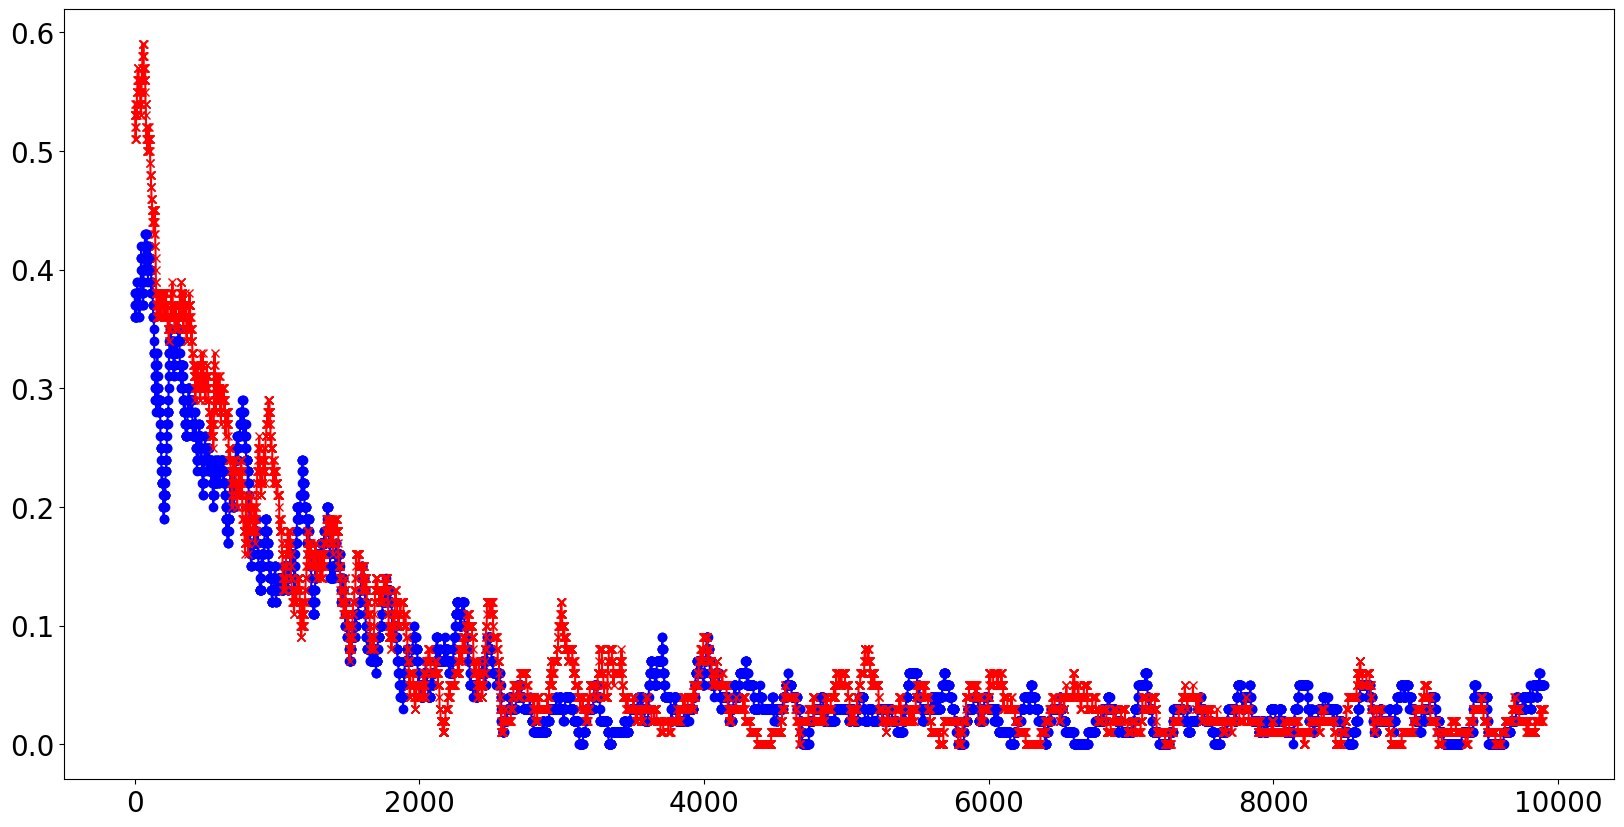

In [25]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting